![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# TFM - Análisis Exploratorio de Datos (EDA)

### Descripción del dataset y su contexto:
El presente dataset contiene información detallada sobre propiedades en venta, incluyendo su precio, ubicación, dimensiones y diversas características adicionales. Cada registro representa un anuncio de un inmueble y cuenta con datos sobre su barrio, distrito, consumo energético y otros atributos socioeconómicos.

El objetivo de este estudio es analizar el conjunto de datos para extraer insights que permitan comprender mejor el mercado inmobiliario y detectar patrones que puedan ser útiles para la toma de decisiones.

### Objetivos del EDA:
1. Comprender la estructura del dataset: Identificar el número de registros y columnas, los tipos de datos y la presencia de valores nulos o inconsistencias.
2. Analizar la distribución de las variables: Explorar la variabilidad en precios, metros cuadrados, ubicaciones y otras características relevantes.
3. Detectar relaciones y correlaciones: Investigar posibles asociaciones entre las variables y su impacto en el precio de los inmuebles.
4. Identificar valores atípicos: Detectar posibles errores o anomalías en los datos que puedan afectar el análisis.
5. Generar insights clave: Extraer información relevante para futuros estudios o modelos de predicción del valor de los inmuebles.

Este análisis servirá como base para entender mejor la dinámica del mercado inmobiliario y podrá ser de utilidad para compradores, vendedores, inversionistas y analistas del sector.

# **_1. Librerías y configuración_**

In [876]:
# Principales
import pandas as pd
import numpy as np

# Modificaciones
import re
#from unidecode import unidecode
import unicodedata
import datetime
import os
import math

# visuzalizaciones
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#import matplotlib as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import missingno as msno
import gc


In [877]:
# Forzar la recolección de basura
gc.collect()

1082229

In [878]:
pd.set_option('display.max_info_columns',110 )
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',80)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)
# Ajustar la configuración para mostrar más filas
# pd.set_option('display.max_rows', 500)

# Inicializar la lista to replace
to_replace=['Null','Nan','nan','NULL',None]

# **_2. Funciones_**

In [879]:
#Funcion que agrupa las columnas por tipo de dato

def columnas_por_tipo(df):
    # Filtrar columnas por tipo de datos
    int_columns = [col for col in df.columns if df[col].dtype.name.startswith('int')]
    float_columns = [col for col in df.columns if df[col].dtype.name.startswith('float')]
    boolean_columns=[col for col in df.columns if set(df[col].unique()) <= {0, 1}]
    numeric_cols=int_columns + float_columns
    object_columns = df.select_dtypes(include='object').columns.tolist()
    category_columns = df.select_dtypes(include='category').columns.tolist()

    cat_columns=list(set(category_columns) - set(boolean_columns) )
    # Obtener todas las columnas
    all_columns = set(df.columns)
    # # Columnas de otros tipos
    other_columns = list(all_columns - set(int_columns) - set(float_columns) - set(object_columns) - set(category_columns))

    # Cuento el número de columnas de cada tipo
    num_int_columns = len(int_columns)
    num_float_columns = len(float_columns)
    num_object_columns = len(object_columns)
    num_category_columns = len(category_columns)
    num_other_columns = len(other_columns)

    # Mostrar los resultados
    print("Número de columnas de tipo entero:", num_int_columns)
    print("Columnas de tipo entero:", int_columns)
    print("Número de columnas de tipo float:", num_float_columns)
    print("Columnas de tipo float:", float_columns)
    print("Número de columnas de tipo object:", num_object_columns)
    print("Columnas de tipo object:", object_columns)
    print("Número de columnas de tipo category:", num_category_columns)
    print("Columnas de tipo category:", category_columns)
    print("Número de columnas de otros tipos:", num_other_columns)
    print("Columnas de otros tipos:", other_columns)
    return boolean_columns,numeric_cols,cat_columns,object_columns,other_columns

In [880]:

def reduce_mem_usage(df, turn_cat=False, silence=True):
    """Itera sobre todo el dataset convirtiendo cada columna en el tipo más adecuado para ahorrar memoria.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe que se quiere reducir.
    turn_cat : bool, optional
        Transformación de las columnas objeto o string a category, by default False.

    Returns
    -------
    pd.DataFrame
        Dataframe optimizado.
    """

    start_mem = df.memory_usage().sum() / 1024**2  # Memoria inicial

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()

            if pd.api.types.is_numeric_dtype(df[col]):
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

                # Conversión de float a int si no hay decimales y no hay NaN
                df[col] = df[col].fillna(0)  # Rellenar NaN antes de verificar si son enteros
                if all(df[col].apply(float.is_integer)):
                    df[col] = df[col].astype(np.int64)

        # Conversión de objetos a categoría si turn_cat es True
        if turn_cat and col_type == object:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # Memoria final

    if not silence:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [881]:
def graficobarrascategoricas(df, colname):
    """Genera un gráfico de barras para una variable categórica, mostrando las 10 categorías más frecuentes y agrupando el resto como 'Otros'.

    Parameters:
    df (DataFrame): El DataFrame que contiene los datos.
    colname (str): Nombre de la variable categórica.

    Returns:
    None
    """
    # Obtener las frecuencias de las categorías
    value_counts = df[colname].value_counts()

    # Seleccionar las 10 categorías más frecuentes
    top_10 = value_counts.head(10)

    # Agrupar el resto en 'Otros'
    other_count = value_counts.tail(len(value_counts) - 10).sum()  # Sumar las frecuencias de las categorías restantes
    if other_count > 0:  # Solo agrupar si hay categorías para agrupar
        otros_series = pd.Series({'Otros': other_count})
        top_10 = pd.concat([top_10, otros_series])  # Usamos pd.concat() en lugar de append

    # Crear el gráfico de barras
    return top_10

In [882]:
def plot_histogram_by_target(df, input_name, target_name, normalize = False):
    """Plots the histogram and boxplot of a numerical variable by target

    Parameters:
    input_name (str): Numeric variable's name
    target_name (str): Target variable's name

    Returns:
    None
    """
    fig = plt.figure(figsize=(15, 6))  # Ajustar el tamaño de la figura según sea necesario
    fig.suptitle(input_name, fontsize=16)


    ax1 = fig.add_subplot(121)
    sns.histplot(data=df, x=input_name, hue=target_name, alpha=.5, bins=25, ax=ax1, stat = 'density', common_norm = not normalize)

    ax2 = fig.add_subplot(122)
    sns.boxplot(data=df, x=target_name, y=input_name, ax=ax2)

    plt.tight_layout()
      # Asegurar que el título de la figura no se superponga
    plt.subplots_adjust(top=0.85)

In [883]:

def plot_barplot_by_target(df, input_name, target_name, stacked=False):
    """
    Grafica un gráfico de barras para una variable categórica en función de una variable objetivo.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos.
    input_name : str
        Nombre de la columna categórica a analizar.
    target_name : str
        Nombre de la columna objetivo (target).
    stacked : bool, opcional, default=False
        Si se debe apilar el gráfico de barras.
    """
    # Crear una tabla de contingencia
    crosstab = pd.crosstab(df[input_name], df[target_name])

    # Crear un gráfico de barras apiladas usando Plotly
    fig = px.bar(crosstab,
                 barmode='stack',  # Esto apila las barras
                # color=crosstab.columns,  # Colores por las columnas
                 title=f'Distribución de {input_name} por {target_name}')

    # Mostrar el gráfico
    fig.update_layout(xaxis_title=input_name,
                      yaxis_title='Frecuencia',
                      xaxis_tickangle=-45)

    fig.show()

In [884]:


def generar_barplot_media_mediana(df, cat_vars, target_var):
    """
    Genera gráficos en dos columnas: barplots con la media y mediana
    de una variable numérica (target_var) frente a varias categóricas.

    :param df: DataFrame de pandas con los datos.
    :param cat_vars: Lista de variables categóricas.
    :param target_var: Variable numérica a analizar (por ejemplo, 'precio').
    """
    filas = len(cat_vars)  # Una fila por variable categórica
    plt.figure(figsize=(15, filas * 5))  # Ajustar tamaño según número de filas

    for i, var in enumerate(cat_vars):
        # Gráfico de la media
        plt.subplot(filas, 2, 2 * i + 1)  # Columna 1: Media
        sns.barplot(x=df[var], y=df[target_var], estimator=np.mean)
        plt.xticks(rotation=90)  # Rotar etiquetas si son largas
        plt.title(f'Media de {target_var} por {var}')
        plt.xlabel(var)
        plt.ylabel(f'Media de {target_var}')

        # Gráfico de la mediana
        plt.subplot(filas, 2, 2 * i + 2)  # Columna 2: Mediana
        sns.barplot(x=df[var], y=df[target_var], estimator=np.median)
        plt.xticks(rotation=90)
        plt.title(f'Mediana de {target_var} por {var}')
        plt.xlabel(var)
        plt.ylabel(f'Mediana de {target_var}')

    plt.tight_layout()  # Ajustar el espacio entre gráficos
    plt.show()


In [885]:
def categorize_ano_construccion(value):
    # Si el valor es NaN, lo dejamos como NaN
    if pd.isna(value):
        return np.nan
    try:
        # Convertimos el valor a float si es numérico
        value = float(value)

        # Asignamos el valor a las franjas de años correspondientes
        if value < 1973:
            return 'Más de 50 años'
        elif 1973 <= value <= 1993:
            return 'Entre 30 y 50 años'
        elif 1993 < value <= 2013:
            return 'Entre 10 y 30 años'
        elif 2013 < value <= 2018:
            return 'Entre 5 y 10 años'
        elif value > 2018:
            return 'Menos de 5 años'
        else:
            return np.nan  # En caso de que no cumpla con ninguna condición
    except:
        # Si el valor no es un número, lo dejamos como está
        value=str(value).strip()

        return value

In [886]:
def agrupar_antiguedad(valor):
    if valor in ['Menos de 5 años', 'Menos de 5 Anos','Menos de 5 Años']:
        return 'Menos de 5 años'
    elif valor in ['Menos de 10 años','Entre 5 y 10 años']:
        return 'Entre 5 y 10 años'
    elif valor in ['Entre 10 y 15 Años','Entre 5 y 10 años','Entre 15 y 20 Años','Entre 10 y 30 años', 'Entre 10 y 20 años', 'Entre 20 y 30 años', 'Entre 15 y 20 Anos','Entre 10 y 15 Anos', 'Entre 15 y 20 años', 'Entre 20 y 25 Anos','Entre 10 y  15 Anos']:
        return 'Entre 10 y 30 años'
    elif valor in ['Entre 25 y 35 años','Entre 35 y 50 Años','Mas de 25 Años','Entre 20 y 25 Años','Entre 30 y 50 años', 'Entre 35 y 50 Anos']:
        return 'Entre 30 y 50 años'
    elif valor in ['Más de 50 años', 'Mas de 50 anos', 'Mas de 25 Anos']:
        return 'Más de 50 años'
    else:
        return valor

# Función para calcular la mediana de m2_contr

def calcular_mediana_colconnulos(row, df, col_connulos, colcomparar1, colcomparar2):
    filtro = (df[colcomparar1] == row[colcomparar1]) & (df[colcomparar2] == row[colcomparar2])
    mediana_colconnulos = df.loc[filtro, col_connulos].median()
    return int(mediana_colconnulos) if not pd.isna(mediana_colconnulos) else mediana_colconnulos

In [887]:

def calcular_mediana_colconnulos(df, col_connulos, colcomparar1, colcomparar2):
    """
    Rellena los valores nulos de col_connulos con la media calculada
    para las filas que coincidan en colcomparar1 y colcomparar2.

    :param df: DataFrame con los datos.
    :param col_connulos: Columna con valores nulos a imputar.
    :param colcomparar1: Primera columna de comparación para el filtro.
    :param colcomparar2: Segunda columna de comparación para el filtro.
    :return: DataFrame con los valores imputados.
    """
    # Iterar sobre las filas donde col_connulos es nulo
    for idx, row in df[df[col_connulos].isna()].iterrows():
        # Filtrar el DataFrame usando colcomparar1 y colcomparar2
        filtro = (df[colcomparar1] == row[colcomparar1]) & (df[colcomparar2] == row[colcomparar2])

        # Calcular la media de col_connulos en ese subconjunto
        mediana = df.loc[filtro, col_connulos].median()

        # Imputar la media si no es NaN
        if not np.isnan(mediana):
            df.at[idx, col_connulos] = mediana

    return df


In [888]:
def extract_num(col):
    try:
        # Si el valor es un número flotante o entero, convertirlo a float (por ejemplo, 1.0 o 2)
        if isinstance(col, (int, float)):
            return float(col)

        # Si el valor es una cadena y contiene un número, extraemos el primer número
        return float(col.split()[0])
    except:
        return np.nan

In [889]:

# Función para identificar si es público o privado
def extract_texto(col, texto1, texto2):
    if isinstance(col, str):  # Solo aplicar 'lower()' si el valor es una cadena
        if texto1 in col.lower():
            return texto1
        elif texto2 in col.lower():
            return texto2
    return np.nan

In [890]:
def asignar_columna(row, diccionario,col_asignar,col_agrupar,colfiltrado,valfiltrado):
    if pd.isnull(row[col_asignar]) and row[colfiltrado] == valfiltrado and pd.notnull(row[col_agrupar]):
        return diccionario.get(row[col_agrupar], 0) + 1
    return row[col_asignar]

In [891]:
#def diccionario_mediana(df,colnulos,colagrup1,colagrup2):
 #   mediana = (df[df[colagrup1].notnull() & dfEDA[colnulos].notnull() ]
  #  .groupby([colagrup1, colagrup2])[colnulos]
   # .median().astype(int))
    #return mediana

In [892]:
def diccionario_mediana(df, colnulos, colagrup1, colagrup2):
    """
    Creates a dictionary where keys are tuples of (colagrup1, colagrup2)
    and values are the median of colnulos for that group.

    :param df: DataFrame with the data.
    :param colnulos: Column with null values to impute.
    :param colagrup1: First column for grouping.
    :param colagrup2: Second column for grouping.
    :return: Dictionary with median values for each group.
    """
    # Filter out rows where colagrup1 or colnulos are null
    filtered_df = df[df[colagrup1].notnull() & df[colnulos].notnull()]

    # Group by colagrup1 and colagrup2, calculate median of colnulos
    mediana = filtered_df.groupby([colagrup1, colagrup2])[colnulos].median().round()
   # mediana=mediana.astype('Int64')
     # Change to 'Int64' only if all values are integers, otherwise keep as float
    if mediana.apply(lambda x: x.is_integer()).all():
        mediana = mediana.astype('Int64')

    # Convert the groupby result to a dictionary for easier lookup
    mediana_dict = mediana.to_dict()

    return mediana_dict



In [893]:
#dfEDA= pd.read_csv('./data/pisosEDA.csv',index_col=False)
dfEDA= pd.read_csv('./pisosEDA.csv',index_col=False)

<ipython-input-893-7feb3def8b73>:2: DtypeWarning:

Columns (9,12,15,20,40,42,43,45,48,52,56) have mixed types. Specify dtype option on import or set low_memory=False.



In [894]:
dfEDA.loc[dfEDA["url"] == "https://www.indomio.es/anuncios/96654135/", "inmueble_ingresos"] = 1


In [895]:
#eLIMINO LAS FILAS con M2_CONSTR nulo
dfEDA=dfEDA.dropna(subset=['m2_constr'])

In [896]:
dfEDA.reset_index(drop=True, inplace=True)

In [897]:
column_name = dfEDA.columns[56]

print(f"El nombre de la columna  45 es: {column_name}")

El nombre de la columna  45 es: puerta_seguridad


In [898]:
# Especificar las columnas para verificar los valores únicos
columns_to_check = [9, 12, 15, 20, 40, 42, 43, 45, 48, 52, 56]

# Obtener los valores únicos para cada columna especificada
unique_values = {col: dfEDA.iloc[:, col].unique() for col in columns_to_check}

# Imprimir los valores únicos
for col, values in unique_values.items():
    print(f"Columna {col}: {values}")


Columna 9: ['Sólo cocina amueblada' 'Sí' nan 'Parcialmente amueblado' 'No' '1.0' 1.0]
Columna 12: ['1' '2' '3+' '3' nan '1.0' '4.0' '3.0' '2.0' '5.0' '6.0' '7.0' '8.0'
 '10.0' '5' '9.0' '11.0' '13.0' '12.0' 2.0 1.0 3.0 4.0 5.0 0.0 11.0 6.0
 7.0 10.0 31.0]
Columna 15: ['2 en garaje privado' '1 en aparcamiento/garaje público' nan
 '1 en garaje privado'
 '1 en garaje privado, 3 en aparcamiento/garaje público'
 '5 en aparcamiento/garaje público' '1' '2 en aparcamiento/garaje público'
 '1 en garaje privado, 1 en aparcamiento/garaje público'
 '4 en aparcamiento/garaje público' '8 en garaje privado'
 '1 en garaje privado, 5 en aparcamiento/garaje público' '0.0'
 '6 en aparcamiento/garaje público' '3 en aparcamiento/garaje público'
 '9 en aparcamiento/garaje público' '10 en aparcamiento/garaje público'
 '2 en garaje privado, 4 en aparcamiento/garaje público'
 '1 en garaje privado, 2 en aparcamiento/garaje público'
 '2 en garaje privado, 2 en aparcamiento/garaje público' 'Más de 2' '2'
 '2.0' '

In [899]:
#columna 45 acceso_discapacidad, eliminar los valores
val=['Exteriores' 'Ver todas las características' 'Otros']
dfEDA['acceso_discapacidad'] = dfEDA['acceso_discapacidad'].replace(val, np.nan)
# Replace '.0' and similar patterns with empty string using regex
dfEDA['acceso_discapacidad'] = dfEDA['acceso_discapacidad'].astype(str).str.replace('.0', '', regex=True)
dfEDA['acceso_discapacidad'] = pd.to_numeric(dfEDA['acceso_discapacidad'], errors='coerce').astype('Int64') # Convert to numeric, handle errors, then to Int64

In [900]:
cols=['amueblado','puerta_seguridad','piscina','jardin']
for c in cols:
  dfEDA[c]=dfEDA[c].astype(str)

In [901]:
cambios = {'3+': '5',  '.0': ''}
# Reemplazar los valores '3+' por 5 en la columna 'banos'
dfEDA['banos'] = dfEDA['banos'].astype(str).replace(cambios).str.strip()
dfEDA['banos'] = pd.to_numeric(dfEDA['banos'], errors='coerce').fillna(0).astype(int)

In [902]:
#56 puerta_seguridad
cambios = {'Puerta acorazada': '1',  'Bombillo seguridad multilock': '1', 'Acorazada': '1','Puerta de entrada blindada':'1','Puerta a la calle':'1','1.0':'1'}
cambiosnan={'Tiene 3 puertas de acceso','Muy cerca centro comercial las rosas, metro y bus.'}
dfEDA['puerta_seguridad'] = dfEDA['puerta_seguridad'].astype(str).replace(cambios).str.strip()
dfEDA['puerta_seguridad'] = dfEDA['puerta_seguridad'].replace(cambiosnan,np.nan)
dfEDA['puerta_seguridad'] = pd.to_numeric(dfEDA['puerta_seguridad'], errors='coerce')
# Change the astype to pd.Int64Dtype() to handle NaN
dfEDA['puerta_seguridad'] = dfEDA['puerta_seguridad'].astype(pd.Int64Dtype())

#En armarios los valores nulos les vamos a poner 0

In [903]:
cambios = {'Más de 2': '4', 'Mas de 5': '7', '.0': ''}
dfEDA['armarios'] = dfEDA['armarios'].replace(cambios).str.strip()
# Convert to numeric, handling errors and filling NaNs with 0
dfEDA['armarios'] = pd.to_numeric(dfEDA['armarios'], errors='coerce').fillna(0).astype(int)

In [904]:
# Especificar las columnas para verificar los valores únicos
columns_to_check = [9, 12, 15, 20, 40, 42, 43, 45, 48, 52, 56]

# Obtener los valores únicos para cada columna especificada
unique_values = {col: dfEDA.iloc[:, col].unique() for col in columns_to_check}

# Imprimir los valores únicos
for col, values in unique_values.items():
    print(f"Columna {col}: {values}")

Columna 9: ['Sólo cocina amueblada' 'Sí' 'nan' 'Parcialmente amueblado' 'No' '1.0']
Columna 12: [ 1  2  5  3  0  4  6  7  8 10  9 11 13 12 31]
Columna 15: ['2 en garaje privado' '1 en aparcamiento/garaje público' nan
 '1 en garaje privado'
 '1 en garaje privado, 3 en aparcamiento/garaje público'
 '5 en aparcamiento/garaje público' '1' '2 en aparcamiento/garaje público'
 '1 en garaje privado, 1 en aparcamiento/garaje público'
 '4 en aparcamiento/garaje público' '8 en garaje privado'
 '1 en garaje privado, 5 en aparcamiento/garaje público' '0.0'
 '6 en aparcamiento/garaje público' '3 en aparcamiento/garaje público'
 '9 en aparcamiento/garaje público' '10 en aparcamiento/garaje público'
 '2 en garaje privado, 4 en aparcamiento/garaje público'
 '1 en garaje privado, 2 en aparcamiento/garaje público'
 '2 en garaje privado, 2 en aparcamiento/garaje público' 'Más de 2' '2'
 '2.0' '1.0' 1.0 0.0 2.0]
Columna 20: ['nan' 'Sin jardín' 'Privado' 'Comunitario' '0.0' '1.0']
Columna 40: ['1' '0' 'nan'

In [905]:
#from google.colab import drive
#drive.mount('/content/drive')

# **_3. Carga de datos_**

In [906]:
print(f"El DataFrame dfEDA tiene {dfEDA.shape[0]} filas y {dfEDA.shape[1]} columnas.")

El DataFrame dfEDA tiene 10035 filas y 113 columnas.


In [907]:
# Compramos que la columna url tiene valores unicos
dfEDA['url'].nunique() == len(dfEDA)

True

In [908]:
dfEDA.columns

Index(['url', 'm2_constr', 'distrito', 'cod_distrito', 'barrio', 'cod_barrio',
       'letra_ce', 'tipologia', 'estado', 'amueblado',
       ...
       'hog_con_11', 'hog_con_12', 'hog_con_13', 'hog_con_14',
       'hog_con_15 y más', 'Comercio_ServiciosMinoristas',
       'Hosteleria_Restauracion', 'Salud_Bienestar_Educacion',
       'Servicios_Profesionales', 'Cultura_Entretenimiento'],
      dtype='object', length=113)

# **_4. Exploración de datos_**

In [909]:
dfEDA.head(2)

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,inmueble_ingresos,alquiler_opcion_a_compra,nuda_propiedad,tipo_inmueble,tiene_armario,cancha_tenis,carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,carpinteria_exterior_triple_vidrio/madera,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc,carpinteria_exterior_vidrio/madera,carpinteria_exterior_vidrio/metal,chimenea,cocina,exterior,interior,interior_y_exterior,piscina,porton_electrico,puerta_blindada,alarma,videoportero,acceso_discapacidad,precio,web,armarios,codigo_Postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,num_visitas,num_pisos,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,Renta neta media por persona,Renta neta media por hogar,Mediana de la renta por unidad de consumo,Renta bruta media por persona,Renta bruta media por hogar,Habitantes,Hogares,Tamaño medio del hogar,Tamaño del hogar (Nº de personas en la vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15 y más,Comercio_ServiciosMinoristas,Hosteleria_Restauracion,Salud_Bienestar_Educacion,Servicios_Profesionales,Cultura_Entretenimiento
0,https://www.indomio.es/anuncios/75404850/,100.00,Salamanca,4,Recoletos,41,F,Atico,Para Reformar,Sólo cocina amueblada,1,1.00,1,1.00,1.00,2 en garaje privado,1.00,1.00,NaN,NaN,nan,NaN,NaN,NaN,lujo,NaN,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,1.00,0.00,0.00,1,0.00,1,0,1.00,1,2000000,Indomio.com,0,28001.00,NaN,NaN,Disponible,NaN,NaN,NaN,1,100,1.00,NaN,NaN,Portero media jornada,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,F,Central,No clasificado en energía,Radiadores,15.44,6.97,8.48,243.00,8.00,235.00,6.00,18.00,NaN,1.00,186.00,NaN,28.14,64.92,31.15,38.75,89.41,145.70,63.88,"2,28",24.74,17.69,9.58,6.90,3.03,1.13,430.00,173.00,98.00,38.00,11.00,10.00,8.00,9.00,30.00,30.00,2470.00,1051.00,928.00,2315.00,917.00
1,https://www.indomio.es/anuncios/79178265/,83.00,Barajas,21,Casco Histórico De Barajas,213,NaN,Piso,Bueno / Habitable,Sí,Entreplanta,2.00,2,0.00,1.00,1 en aparcamiento/garaje público,0.00,1.00,2009,2.00,nan,1.00,NaN,NaN,medio,NaN,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Cocina abierta,0.00,1.00,0.00,0,0.00,1,0,0.00,1,287000,Indomio.com,0,28042.00,NaN,NaN,No indicado,NaN,NaN,NaN,1,123,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Sin Aire,abierta,0.00,NaN,Individual,Electrica,Radiadores,7.38,3.52,3.87,94.00,12.00,82.00,2.00,6.00,NaN,2.00,144.00,NaN,20.79,54.34,26.95,27.12,70.91,48.65,18.52,"2,63",4.69,5.05,3.83,3.44,1.00,290.00,113.00,44.00,39.00,12.00,3.00,3.00,0.00,0.00,7.00,7.00,399.00,345.00,125.00,522.00,108.00


In [910]:
dfEDA.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
url,10035,10035,https://www.indomio.es/anuncios/75404850/,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m2_constr,10035.00,NaN,NaN,NaN,138.53,152.06,0.00,68.00,98.00,150.00,4574.00
distrito,10035,21,Centro,1781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cod_distrito,10035.00,NaN,NaN,NaN,7.78,5.76,1.00,4.00,6.00,12.00,21.00
barrio,10035,132,Goya,442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Comercio_ServiciosMinoristas,10035.00,NaN,NaN,NaN,1209.26,707.44,0.00,693.00,1208.00,1495.00,2470.00
Hosteleria_Restauracion,10035.00,NaN,NaN,NaN,630.90,386.03,0.00,274.00,589.00,1051.00,1116.00
Salud_Bienestar_Educacion,10035.00,NaN,NaN,NaN,389.90,322.23,0.00,137.00,267.00,494.00,1039.00
Servicios_Profesionales,10035.00,NaN,NaN,NaN,937.81,735.14,0.00,505.00,628.00,1502.00,2315.00


In [911]:
# Tratar las columnas para quitar espacios si tuvieran y poner el nombre de las columnas en minúsculas
# para tener desde el primer momento siempre el mismo nombre de columnas.
dfEDA.columns = [col.strip().lower() for col in dfEDA.columns]

In [912]:
dfEDA.columns.tolist()

['url',
 'm2_constr',
 'distrito',
 'cod_distrito',
 'barrio',
 'cod_barrio',
 'letra_ce',
 'tipologia',
 'estado',
 'amueblado',
 'planta',
 'dormitorios',
 'banos',
 'balcon',
 'terraza',
 'garaje',
 'trastero',
 'ascensor',
 'antiguedad',
 'num_plantas',
 'jardin',
 'inmueble_ingresos',
 'alquiler_opcion_a_compra',
 'nuda_propiedad',
 'tipo_inmueble',
 'tiene_armario',
 'cancha_tenis',
 'carpinteria_exterior_doble_vidrio/pvc',
 'carpinteria_exterior_doble_vidrio/madera',
 'carpinteria_exterior_doble_vidrio/metal',
 'carpinteria_exterior_triple_vidrio/madera',
 'carpinteria_exterior_triple_vidrio/metal',
 'carpinteria_exterior_vidrio/pvc',
 'carpinteria_exterior_vidrio/madera',
 'carpinteria_exterior_vidrio/metal',
 'chimenea',
 'cocina',
 'exterior',
 'interior',
 'interior_y_exterior',
 'piscina',
 'porton_electrico',
 'puerta_blindada',
 'alarma',
 'videoportero',
 'acceso_discapacidad',
 'precio',
 'web',
 'armarios',
 'codigo_postal',
 'm2_utiles',
 'tipo_suelo',
 'certificado_e

## 4.1 Tipo de datos

In [913]:
# Función `columnas_por_tipo` que muestra un resumen de los tipo de columnas que hay en el dataframe
# boolean_columns, numeric_cols, cat_columns, object_columns, other_columns
cols_bool, cols_num, cols_cat, cols_obj, cols_other = columnas_por_tipo(dfEDA)
print("Booleans:", cols_bool)
print("Numéricas:", cols_num)
print("Categóricas:", cols_cat)
print("Objeto:", cols_obj)
print("Otras:", cols_other)

Número de columnas de tipo entero: 5
Columnas de tipo entero: ['cod_distrito', 'cod_barrio', 'banos', 'precio', 'armarios']
Número de columnas de tipo float: 75
Columnas de tipo float: ['m2_constr', 'dormitorios', 'balcon', 'terraza', 'trastero', 'ascensor', 'num_plantas', 'inmueble_ingresos', 'alquiler_opcion_a_compra', 'nuda_propiedad', 'tiene_armario', 'cancha_tenis', 'carpinteria_exterior_doble_vidrio/pvc', 'carpinteria_exterior_doble_vidrio/madera', 'carpinteria_exterior_doble_vidrio/metal', 'carpinteria_exterior_triple_vidrio/madera', 'carpinteria_exterior_triple_vidrio/metal', 'carpinteria_exterior_vidrio/pvc', 'carpinteria_exterior_vidrio/madera', 'carpinteria_exterior_vidrio/metal', 'chimenea', 'exterior', 'interior', 'interior_y_exterior', 'porton_electrico', 'videoportero', 'codigo_postal', 'm2_utiles', 'tiene_jardin', 'num_visitas', 'tiene_piscina', 'orientacion_este', 'orientacion_oeste', 'orientacion_sur', 'orientacion_norte', 'num_personas', 'num_personas_hombres', 'num_

## 4.2 Identificacion de valores nulos


Identificación de Valores Nulos

Los valores nulos pueden afectar los análisis estadísticos y las visualizaciones. Para detectarlos, revisaremos:
- La cantidad de valores nulos por columna.
- El porcentaje de valores nulos en relación con el total de datos.
- Visualización de los valores nulos para identificar patrones.

### 4.2.1 Número de valores nulos por columna

In [914]:
# Verificar valores nulos por columna
valores_nulos = dfEDA.isnull().sum()

print("Valores nulos por columna:")
print(valores_nulos[valores_nulos > 0])

Valores nulos por columna:
letra_ce                                      7885
estado                                        4521
planta                                        4562
dormitorios                                    225
balcon                                        8619
terraza                                       7580
garaje                                        8072
trastero                                      7388
ascensor                                      5461
antiguedad                                    6636
num_plantas                                   9819
inmueble_ingresos                            10025
alquiler_opcion_a_compra                     10032
nuda_propiedad                               10023
tipo_inmueble                                 8143
tiene_armario                                 8151
cancha_tenis                                  6987
carpinteria_exterior_doble_vidrio/pvc         6629
carpinteria_exterior_doble_vidrio/madera      6987
carp

### 4.2.2 Porcentaje de nulos por columna

In [915]:
# Ver porcentaje de valores nulos
porcentaje_nulos = (dfEDA.isnull().sum() / len(dfEDA)) * 100

print("\nPorcentaje de valores nulos por columna:")
print(porcentaje_nulos[porcentaje_nulos > 0])


Porcentaje de valores nulos por columna:
letra_ce                                    78.57
estado                                      45.05
planta                                      45.46
dormitorios                                  2.24
balcon                                      85.89
terraza                                     75.54
garaje                                      80.44
trastero                                    73.62
ascensor                                    54.42
antiguedad                                  66.13
num_plantas                                 97.85
inmueble_ingresos                           99.90
alquiler_opcion_a_compra                    99.97
nuda_propiedad                              99.88
tipo_inmueble                               81.15
tiene_armario                               81.23
cancha_tenis                                69.63
carpinteria_exterior_doble_vidrio/pvc       66.06
carpinteria_exterior_doble_vidrio/madera    69.63
carpinte

## 4.2.3 Visulización de nulos

In [916]:

# Convertir valores nulos en 1 y valores no nulos en 0
df_nulos = dfEDA.isnull().astype(int)

# Graficar con imshow (MUCHO MÁS RÁPIDO)
fig = px.imshow(df_nulos, labels={'x': 'Columnas', 'y': 'Índices', 'color': 'Nulo'},
                color_continuous_scale='blues', title="Mapa de Valores Nulos")
#silvia comento los graficos para que no pese, quitar el comentario para analizarlos
#fig.show()


#### 🚩
Explicación de las gráficas
En las partes resaltadras con mayor intensidad de color hacen referencia a las variables/ columnas con mayor cantidad de valores nulos. Gracias a ello, podemos ver de manera clara si los nulos se encuentran al principio, al final , entre medio o algun otro lugar de la columna. Tambien podemos notar que especialmente las variables que empiezan con la palabra carpiteria y cancha_tenis tienen una gran cantidad de nulos al igual que otras variables.

## 4.3 Identificación de datos duplicados

Identificación de Datos Duplicados
- Los registros duplicados pueden distorsionar el análisis y deben ser detectados para evaluar si deben eliminarse.

In [917]:
duplicados = dfEDA.duplicated().sum()

print(f"\nNúmero de registros duplicados: {duplicados}")


Número de registros duplicados: 0


In [918]:
# Mostrar ejemplos de registros duplicados (si existen)
if duplicados > 0:
    print("\nEjemplo de registros duplicados:")
    display(dfEDA[dfEDA.duplicated()].head())

# **_5. Variable target_**


In [919]:
# Distribución de la variable target en porcentaje
dfEDA["precio"].value_counts(normalize = True)

,proportion
precio,
220000,0.01
230000,0.01
280000,0.01
240000,0.01
650000,0.01
...,...
3090000,0.00
691900,0.00
296900,0.00


In [920]:
dfEDA.precio.describe(percentiles=[0.15,0.3,0.45,0.55,0.75,0.9])

,precio
count,10035.00
mean,889074.50
std,1159555.24
min,25000.00
15%,185000.00
30%,269000.00
45%,402930.00
50%,480000.00
55%,580000.00
75%,1090000.00


## 5.1 Valores atípicos

In [921]:
# Detectar valores atípicos con IQR
Q1 = dfEDA['precio'].quantile(0.25)
Q3 = dfEDA['precio'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar valores atípicos
outliers = dfEDA[(dfEDA['precio'] < limite_inferior) | (dfEDA['precio'] > limite_superior)]
print(f'Cantidad de valores atípicos en precio: {len(outliers)}')

Cantidad de valores atípicos en precio: 806


In [922]:
dfEDA.query("precio<50000 or precio>9000000")

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,inmueble_ingresos,alquiler_opcion_a_compra,nuda_propiedad,tipo_inmueble,tiene_armario,cancha_tenis,carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,carpinteria_exterior_triple_vidrio/madera,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc,carpinteria_exterior_vidrio/madera,carpinteria_exterior_vidrio/metal,chimenea,cocina,exterior,interior,interior_y_exterior,piscina,porton_electrico,puerta_blindada,alarma,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,num_visitas,num_pisos,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta neta media por persona,renta neta media por hogar,mediana de la renta por unidad de consumo,renta bruta media por persona,renta bruta media por hogar,habitantes,hogares,tamaño medio del hogar,tamaño del hogar (nº de personas en la vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15 y más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento
513,https://www.indomio.es/anuncios/95469291/,3250.00,Fuencarral-El Pardo,8,Peñagrande,83,NaN,Casa,NaN,nan,NaN,9.00,5,NaN,1.00,2 en aparcamiento/garaje público,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,lujo,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,NaN,0.00,0.00,0.00,1,0.00,0,0,0.00,<NA>,11500000,Indomio.com,0,28035.00,NaN,NaN,No indicado,NaN,NaN,NaN,0,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,NaN,No clasif,No clasificado en energía,Radiadores,44.34,20.60,23.74,336.00,20.00,316.00,3.00,14.00,2.00,5.00,448.00,NaN,21.95,58.21,28.35,28.80,76.39,248.44,92.89,"2,67",23.92,25.43,18.30,15.88,5.85,1.96,777.00,358.00,198.00,71.00,53.00,32.00,13.00,5.00,48.00,48.00,197.00,95.00,148.00,121.00,99.00
561,https://www.indomio.es/anuncios/95507473/,135.00,Centro,1,Embajadores,12,E,Piso,NaN,nan,4,3.00,2,0.00,0.00,NaN,0.00,1.00,1936,NaN,Sin jardín,NaN,NaN,NaN,lujo,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0,0.00,0,0,0.00,0,9500000,Indomio.com,0,28012.00,NaN,NaN,Disponible,0.00,NaN,NaN,0,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,E,No clasif,No clasificado en energía,Radiadores,46.20,24.09,22.11,750.00,9.00,741.00,7.00,27.00,NaN,2.00,181.00,756.00,20.59,41.06,22.05,27.03,53.91,139.69,70.32,"1,99",34.16,19.87,8.27,4.59,1.80,750.00,388.00,162.00,101.00,74.00,43.00,36.00,20.00,11.00,48.00,48.00,1208.00,1054.00,137.00,582.00,259.00
825,https://www.indomio.es/anuncios/95960067/,509.00,Salamanca,4,Recoletos,41,NaN,Piso,Bueno / Habitable,nan,5,4.00,5,NaN,NaN,NaN,0.00,1.00,1900,NaN,Sin jardín,NaN,NaN,NaN,lujo,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0,0.00,0,0,0.00,<NA>,9800000,Indomio.com,0,28001.00,NaN,NaN,No indicado,0.00,NaN,NaN,0,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Normal,sin_informacion,0.00,NaN,No clasif,No clasificado en energía,Radiadores,15.44,6.97,8.48,243.00,8.00,235.00,6.00,18.00,NaN,1.00,186.00,NaN,28.14,64.92,31.15,38.75,89.41,145.70,63.88,"2,28",24.74,17.69,9.58,6.90,3.03,1.13,430.00,173.00,98.00,38.00,11.00,10.00,8.00,9.00,30.00,30.00,2470.00,1051.00,928.00,2315.00,917.00
1118,https://www.in

**_Se han revisado las web de anuncios con precios atipicos y son correctos_**

In [923]:
dfEDA.drop_duplicates(keep='first', inplace=True)

# 5.2 Distribución

In [924]:
# HISTOGRAMA
fig = px.histogram(dfEDA,x="precio", nbins=100,title='Precio en Euros', labels={'value': 'Precio'})
fig.show()

#### 🚩
Explicación de las gráficas

En el grafico mostrado se puede visualizar claramente la distribucion de las viviendas segun su precio. Gracias a ello podemos percatarnos que hay una notable mayor cantidad de viviendas con un rango de 200 k - 400 k euros a a diferencia de las demas viviendas donde la cantidad de las mismas empieza a disminuir. Tambien se puede notar que hay varios outliers o en otras palabras viviendas que salen considerablemente de donde se encuentra el mayor numero de viviendas teniendo un precio sumamente mayor al de donde se encuentran el mayor numero de viviendas.  En conclusion, el mayor numero de viviendas se concentra en valores menores a 1 millon de euros y tenemos viviendas con precios que pueden llegar a ser mayores a 18 millones de euros lo que es algo poco comun.

# **_6. Análisis estadístico inicial_**

### **_6.1 Análisis univariado_**
El análisis univariado permite estudiar la distribución de cada variable por separado, identificando patrones, valores atípicos y posibles problemas en los datos.

#### **_6.1.1 Variables numéricas_**
Las variables numéricas se pueden analizar mediante histogramas para observar su distribución y boxplots o gráficos de violín para detectar posibles valores atípicos.

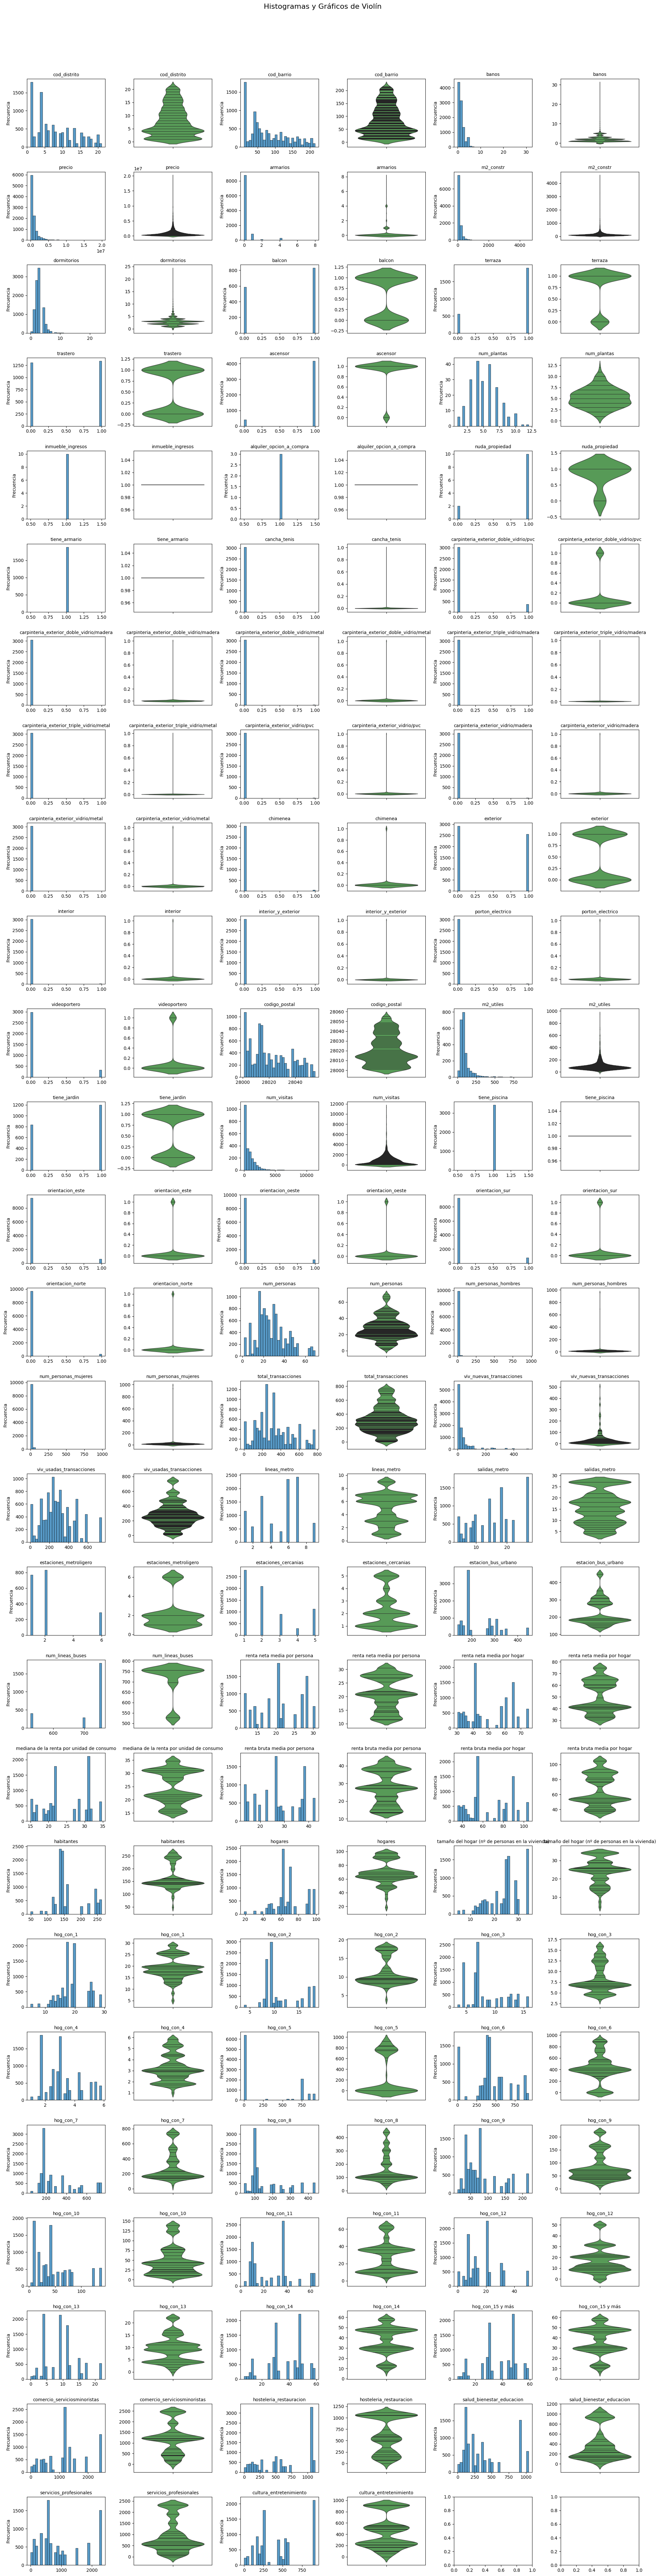

In [925]:
#Gráfico con histogramas y violín

# Parámetros
var_porfila = 3  # Número de variables por fila
graf_porvariable = 2  # Histograma y violín
tot_var = len(cols_num)

# Calcular el número de filas y columnas
n_cols = var_porfila * graf_porvariable  # Total de columnas por fila
n_rows = math.ceil(tot_var / var_porfila)  # Número de filas necesarias

# Crear subplots dinámicamente
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 3 * n_rows))
fig.suptitle('Histogramas y Gráficos de Violín', fontsize=16)

if n_rows == 1:
    axes = axes.reshape(1, -1)  # Convierte a 2D si hay solo una fila

# Añadir gráficos
for i, col in enumerate(cols_num):
    row = i // var_porfila  # Fila correspondiente
    col_hist = (i % var_porfila) * graf_porvariable  # Columna del histograma
    col_violin = col_hist + 1  # Columna del gráfico de violín

    # Histograma
    sns.histplot(dfEDA[col].dropna(), bins=30, ax=axes[row, col_hist])
    axes[row, col_hist].set_title(f'{col}', fontsize=10)
    axes[row, col_hist].set_xlabel("")
    axes[row, col_hist].set_ylabel("Frecuencia")

    # Gráfico de violín

    sns.violinplot(y=dfEDA[col].dropna(), ax=axes[row, col_violin], inner="stick", color='green', alpha=0.7)

    axes[row, col_violin].set_title(f'{col}', fontsize=10)
    axes[row, col_violin].set_ylabel("")
    axes[row, col_violin].set_xlabel("")

# Ajustar el diseño
plt.tight_layout(rect=[0, 0, 1, 0.96])
#silvia comento los graficos para que no pese, quitar el comentario para analizarlos
#fig.show()


#### 🚩
Interpretación de las gráficas.

##############################################
##################################3333
######################
Silvia: Aqui jhay que revasar las graficas y decir que variables llaman la atención por algun motivo, para tenerlo en cuenta mas adelante.El comentario de abajo no aporta nada al analisis del proyecto.

En la visualizacion mostrada se puede apreciar claramente las distribuciones de las variables numericas/ columnas con valores numericos. Se puede apreciar que hay varias columnas con valores binarios o sea que solo manejan 0 y 1 como valores. Tambien se puede notar que hay algunas variables principalmente las binarias, que en su mayoria estan compuestas por valores igual a 0, lo que significa que no nos aportan mucha informacion y deberiamos analizar que tan importante es esa poca informacion que nos aportan para ver si se sigue conservando. Dentro de las demas variables se pueden notar distribuciones mas variadas.

#### **_6.1.2 Variables categóricas_**
Para las variables categóricas, los gráficos de barras ayudan a visualizar la frecuencia de cada categoría.

In [926]:
# Convertimos a categoricas las siguientes variables, barrio, distrito,letra_ce, tipologia,estado,tipo_inmueble,cocina,tipo_suelo,tipo_fachada,agua_caliente,grupo_cocina,
#letra_emisiones,tipo_calefaccion,energia_calefaccioninstalacion_calefaccion

cols = ["barrio", "distrito", "letra_ce", "tipologia", "estado", "tipo_inmueble",
        "cocina", "tipo_suelo", "tipo_fachada", "agua_caliente", "grupo_cocina",
        "letra_emisiones", "tipo_calefaccion", "energia_calefaccion", "instalacion_calefaccion"]

for c in cols:
    # Convertir 'categoría' a categórica
    dfEDA[c] = dfEDA[c].astype('category')

In [927]:
# Función `columnas_por_tipo` que muestra un resumen de los tipo de columnas que hay en el dataframe
# boolean_columns, numeric_cols, cat_columns, object_columns, other_columns
cols_bool, cols_num, cols_cat, cols_obj, cols_other = columnas_por_tipo(dfEDA)
print("Booleans:", cols_bool)
print("Numéricas:", cols_num)
print("Categóricas:", cols_cat)
print("Objeto:", cols_obj)
print("Otras:", cols_other)

Número de columnas de tipo entero: 5
Columnas de tipo entero: ['cod_distrito', 'cod_barrio', 'banos', 'precio', 'armarios']
Número de columnas de tipo float: 75
Columnas de tipo float: ['m2_constr', 'dormitorios', 'balcon', 'terraza', 'trastero', 'ascensor', 'num_plantas', 'inmueble_ingresos', 'alquiler_opcion_a_compra', 'nuda_propiedad', 'tiene_armario', 'cancha_tenis', 'carpinteria_exterior_doble_vidrio/pvc', 'carpinteria_exterior_doble_vidrio/madera', 'carpinteria_exterior_doble_vidrio/metal', 'carpinteria_exterior_triple_vidrio/madera', 'carpinteria_exterior_triple_vidrio/metal', 'carpinteria_exterior_vidrio/pvc', 'carpinteria_exterior_vidrio/madera', 'carpinteria_exterior_vidrio/metal', 'chimenea', 'exterior', 'interior', 'interior_y_exterior', 'porton_electrico', 'videoportero', 'codigo_postal', 'm2_utiles', 'tiene_jardin', 'num_visitas', 'tiene_piscina', 'orientacion_este', 'orientacion_oeste', 'orientacion_sur', 'orientacion_norte', 'num_personas', 'num_personas_hombres', 'num_

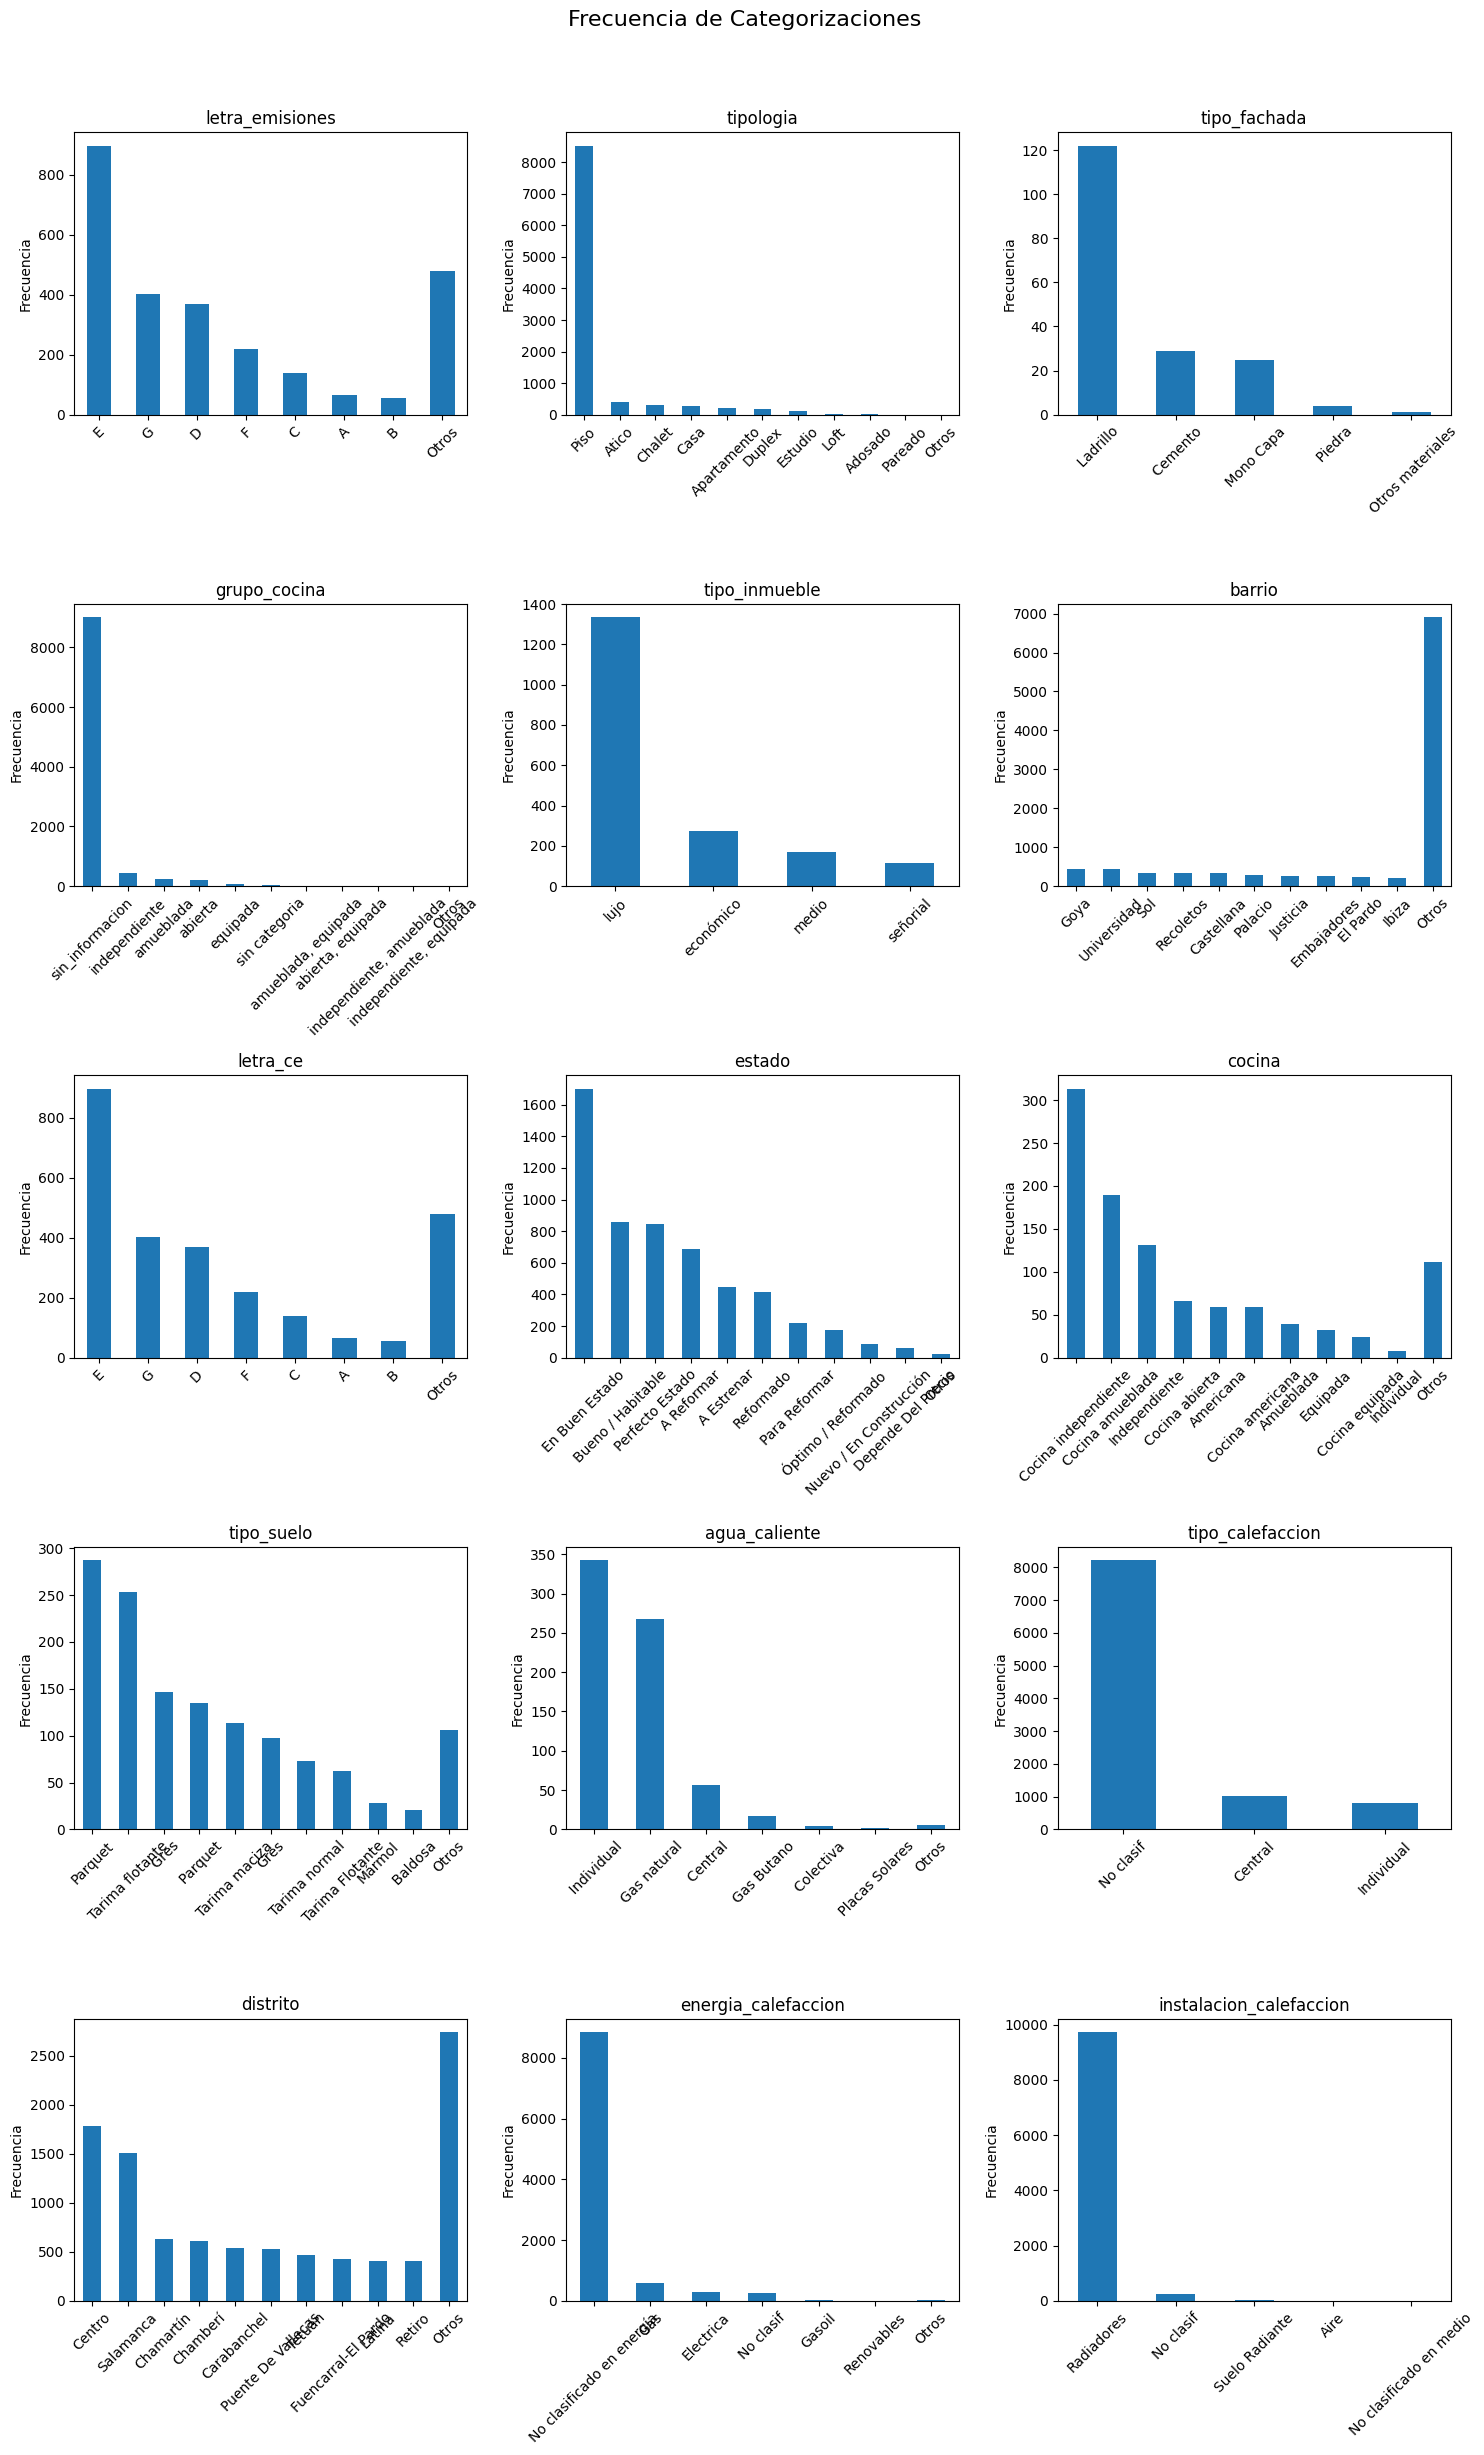

In [928]:
# Definir el número de gráficos por fila
num_por_fila = 3
listacol=cols_cat
# Calcular el número de filas necesarias
num_filas = (len(listacol) + num_por_fila - 1) // num_por_fila  # Redondea hacia arriba para cubrir todos los gráficos

# Crear la figura con subplots
fig, axes = plt.subplots(nrows=num_filas, ncols=num_por_fila, figsize=(15, 5 * num_filas))
fig.suptitle("Frecuencia de Categorizaciones", fontsize=16)

 # Asegurarse de que `axes` es 2D
#axes = axes.reshape(num_filas, num_por_fila)
#Bucle para crear los gráficos en cada fila
for i, col in enumerate(listacol):
    # Obtener la fila y columna correspondiente
    row = i // num_por_fila
    col_idx = i % num_por_fila

    # Crear el gráfico de barras
    top_10 = graficobarrascategoricas(dfEDA, col)

    # Dibujar el gráfico de barras
    top_10.plot(kind='bar', ax=axes[row, col_idx])

    # Configurar los títulos y etiquetas
    axes[row, col_idx].set_title(f'{col}', fontsize=12)
    axes[row, col_idx].set_xlabel("")
    axes[row, col_idx].set_ylabel("Frecuencia")

    # Rotar las etiquetas del eje X
    axes[row, col_idx].tick_params(axis='x', rotation=45)

    # Ajustar el diseño
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el diseño para que no se superpongan

#silvia comento los graficos para que no pese, quitar el comentario para analizarlos
#fig.show()





### **_6.2 Análisis bivariado_**
El análisis bivariado nos permite estudiar la relación entre dos variables, ya sean numéricas o categóricas.

#### **_6.2.2 Variables numéricas_**


#### Pairplots para ver la relación entre algunas de las variables numericas

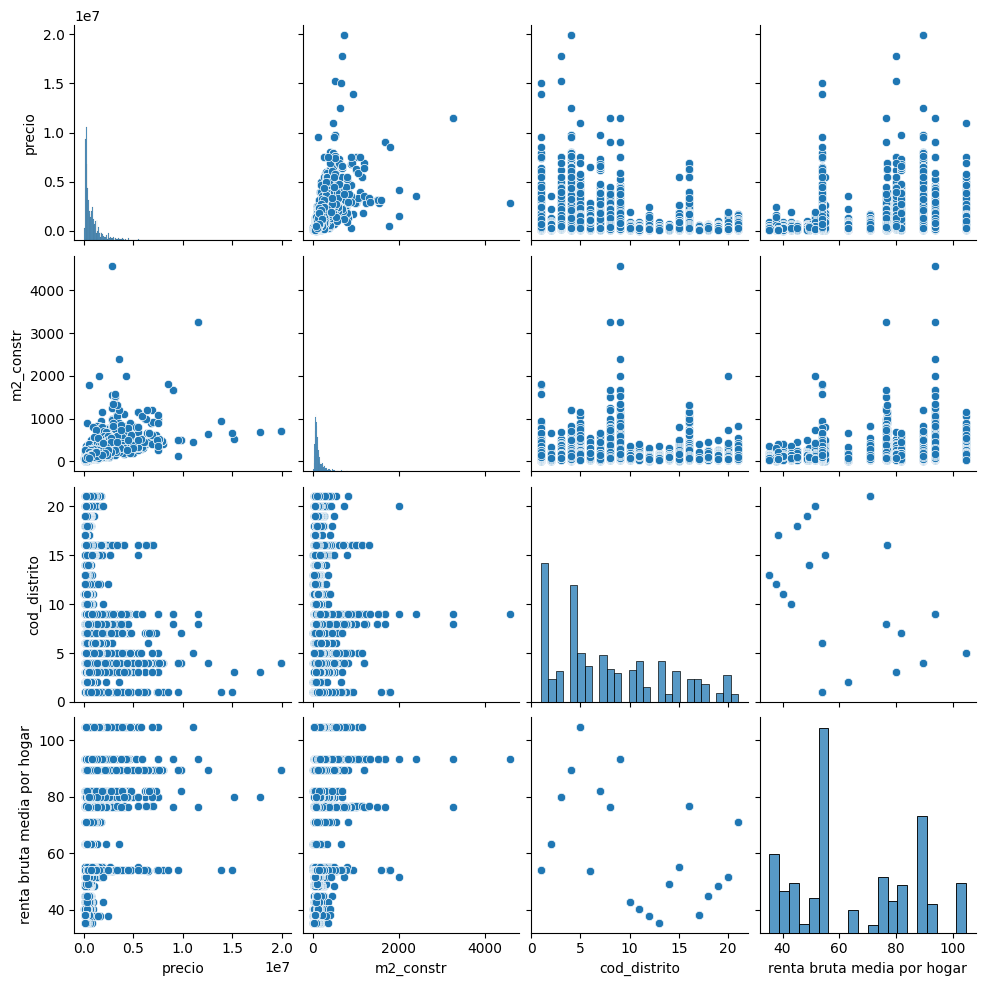

In [929]:
# Pairplot de variables numéricas claves
sns.pairplot(dfEDA[['precio', 'm2_constr', 'cod_distrito','renta bruta media por hogar']])




##### SLVIA , LOS GRAFICOS HAY QUE EXPLICARLOS CON ALGO SIMILAR A ESTO
Explicacion de la grafica

1. precio vs. m2_constr:Hay una correlación positiva, a medida que aumenta el tamaño construido (metros cuadrados), el precio tiende a incrementarse. La dispersión  muestra una nube de puntos con una tendencia ascendente.

2. precio vs. cod_distrito:La relación entre precio y código de distrito es menos clara. Es probable que el gráfico refleje precios variados dentro de cada distrito,y que el  distrito afecte, pero de manera categórica. Será necesario analizar la comparación de medias por distrito.

3. precio vs. renta bruta media por hogar: Hay una gran dispersión en los puntos por lo que la distribución no parece lineal.
Podemos ver acumulación de puntos en la parte inferior izquierda , lo que indicaria que las viviendas con precios bajos estan asociados a las rentas más bajas.En las zonas con rentas altas parece haber algo más de variabilidad con algunos valores extremos. Aunque hay dispersión, es posible que exista una relación positiva entre la renta media por hogar y el precioprecio de vivienda.


#### Matriz de correlación y heatmap

Utilizamos la matriz de correlación para  identificar relaciones entre variables numéricas.

In [930]:
df_corr=dfEDA.corr(numeric_only=True).copy()
#silvia comento los graficos para que no pese, quitar el comentario para analizarlos

#df_corr.style.background_gradient(cmap="Greens",axis=None)


In [931]:


# Seleccionar solo las columnas numéricas
numericas = dfEDA.select_dtypes(include=[np.number])


# Calcular la correlación de 'var1' con las demás columnas numéricas
correlaciones = numericas.corrwith(numericas['precio'])

print("Correlación de 'var1' con las demás variables numéricas:")
print(correlaciones)


Correlación de 'var1' con las demás variables numéricas:
m2_constr                       0.67
cod_distrito                   -0.27
cod_barrio                     -0.27
dormitorios                     0.44
banos                           0.65
                                ... 
comercio_serviciosminoristas    0.26
hosteleria_restauracion         0.22
salud_bienestar_educacion       0.30
servicios_profesionales         0.30
cultura_entretenimiento         0.24
Length: 82, dtype: float64


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



#### 🚩
Explicación de la gráfica

Se puede apreciar una especial correlacion entre la variable precio con la de dormitorio m2_utiles, renta bruta media por hogar, renta bruta media por persona, mediana de la renta por unidad de consumo, renta neta media por hogar, renta neta media por persona. Las demas variables cuentan con una relacion hacia la variable precio mucho mas baja.


In [932]:
# Distribución de variables numéricas


# # Selecciono un subconjunto de variables numericas para hacer el estudio
# cols= ['m2_constr', 'cod_barrio','cod_distrito']
# for c in cols:
#     plot_histogram_by_target(df = dfEDA.sort_values("precio"), input_name = c, target_name = 'precio', normalize = True)

#### 🚩
Explicación de las gráficas


#### **_6.2.2 Variables categoricas_**


Analizamos la relación de la variable target con las varaibles categoricas


In [933]:
#silvia comento los graficos para que no pese, quitar el comentario para analizarlos

#generar_barplot_media_mediana(dfEDA, cols_cat, 'precio')

#### 🚩
Explicación de las gráficas

En esta grafica se puede aprecias claramente la distriburcion e influencia de el distrito sobre el precio. Logrando asi comprender como conclusion que el precio cambiara significativamente segun el distrito donde quieras vivir.

# **_6. Limpieza de datos_**

In [934]:
dfEDA["distrito"].value_counts(dropna=False)

,count
distrito,
Centro,1781
Salamanca,1510
Chamartín,635
Chamberí,609
Carabanchel,537
Puente De Vallecas,525
Tetuán,463
Fuencarral-El Pardo,424
Latina,408


### **_6.1 Eliminación de duplicados_**

In [935]:
# Comprobamos si hay filas duplicadas
len(dfEDA.drop_duplicates()) / len(dfEDA)

1.0

### **_6.2 Tratamiento de nulos_**
Dependiendo de la cantidad de valores nulos y duplicados detectados, se pueden tomar las siguientes acciones:
- Eliminar registros con muchos valores nulos si afectan el análisis.
- Imputar valores faltantes
- Eliminar registros duplicados si no aportan valor al análisis.

In [936]:
for col in dfEDA.columns:
    porcentaje_nulos = dfEDA[col].isnull().mean() * 100
    if porcentaje_nulos > 90:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

Columna num_plantas: 97.85% nulos
Columna inmueble_ingresos: 99.90% nulos
Columna alquiler_opcion_a_compra: 99.97% nulos
Columna nuda_propiedad: 99.88% nulos
Columna acceso_discapacidad: 97.53% nulos
Columna num_pisos: 99.84% nulos
Columna gastos_comunidad: 94.63% nulos
Columna tipo_fachada: 98.20% nulos
Columna agua_caliente: 93.13% nulos
Columna portero: 97.72% nulos


Las columnas Columna inmueble_ingresos: 99.91% nulos
Columna alquiler_opcion_a_compra: 99.97% nulos
Columna nuda_propiedad: 99.87% nulos hacen referencia a viviendas con algún tipo de venta, inmuebles_ingresos son viviendas alquiladas
nuda_propiedad son viviendas de las que no se tienen la posesion. La muestra es muy baja por lo que voy a eliminar ese tipo de viviendas y haremos solo el modelo para viviendas de venta libre de cargas

In [937]:
#eliminar viviendas con esas columnas con valor 1 y despues eliminar las
dfEDA.query("inmueble_ingresos==1 | alquiler_opcion_a_compra==1 | nuda_propiedad==1").count()

,0
url,23
m2_constr,23
distrito,23
cod_distrito,23
barrio,23
...,...
comercio_serviciosminoristas,23
hosteleria_restauracion,23
salud_bienestar_educacion,23
servicios_profesionales,23


In [938]:
dfEDA.shape

(10035, 113)

In [939]:
# Get the index of the rows to be removed
eliminar_filas = dfEDA.query("inmueble_ingresos==1 | alquiler_opcion_a_compra==1 | nuda_propiedad==1").index

# Keep only the rows that are NOT in the index_to_remove
dfEDA = dfEDA[~dfEDA.index.isin(eliminar_filas)]

In [940]:
dfEDA.shape

(10012, 113)

In [941]:
#Eliminamos la columnas
dfEDA.drop(columns=['inmueble_ingresos', 'alquiler_opcion_a_compra', 'nuda_propiedad'], inplace=True)

In [942]:
# Comprobamos si hay columnas con un 95% de los datos iguales, que no sean columnas con 0 y 1, en ese caso se eliminarán estas columnas
[col for col in dfEDA.columns if dfEDA[col].value_counts(normalize=True).max() >= 0.95]

['tiene_armario',
 'cancha_tenis',
 'carpinteria_exterior_doble_vidrio/madera',
 'carpinteria_exterior_doble_vidrio/metal',
 'carpinteria_exterior_triple_vidrio/madera',
 'carpinteria_exterior_triple_vidrio/metal',
 'carpinteria_exterior_vidrio/pvc',
 'carpinteria_exterior_vidrio/madera',
 'carpinteria_exterior_vidrio/metal',
 'chimenea',
 'interior',
 'interior_y_exterior',
 'porton_electrico',
 'puerta_blindada',
 'alarma',
 'puerta_seguridad',
 'tiene_piscina',
 'orientacion_oeste',
 'orientacion_norte',
 'instalacion_calefaccion']

In [943]:
#Solo tenemos el caso de la columnas instalación calefaccion que tiene mas del 95% de los valores 'Radiadores'
dfEDA["instalacion_calefaccion"].value_counts(dropna=False)

,count
instalacion_calefaccion,
Radiadores,9706
No clasif,268
Suelo Radiante,21
Aire,13
No clasificado en medio,4


## 🚩
REVISAR SI VAMOS A ELIMINAR CON ESTOS UMBRLES, DE MOMENTO LO COMENTO

In [944]:
# Eliminamos LAS COLUMNAS con un porcentaje de nulos mayor del 65 % y las columnas desequilibradas en las que una categoría contiene el 95% o mas de los datos.
# umbral = len(dfEDA) * 0.35

# Eliminar columnas con más del 90% de valores nulos
# dfEDA = dfEDA.dropna(axis=1, thresh=umbral)
# dfEDA = dfEDA.drop(columns=[col for col in dfEDA.columns if dfEDA[col].value_counts(normalize=True).max() >= 0.95])
# dfEDA.shape

In [945]:
# Comprobar las columnas que tenen nulos
for col in dfEDA.columns:
    porcentaje_nulos = dfEDA[col].isnull().mean() * 100
    if porcentaje_nulos > 0:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

Columna letra_ce: 78.61% nulos
Columna estado: 45.04% nulos
Columna planta: 45.46% nulos
Columna dormitorios: 2.24% nulos
Columna balcon: 85.92% nulos
Columna terraza: 75.54% nulos
Columna garaje: 80.52% nulos
Columna trastero: 73.67% nulos
Columna ascensor: 54.41% nulos
Columna antiguedad: 66.16% nulos
Columna num_plantas: 97.96% nulos
Columna tipo_inmueble: 81.17% nulos
Columna tiene_armario: 81.25% nulos
Columna cancha_tenis: 69.68% nulos
Columna carpinteria_exterior_doble_vidrio/pvc: 66.10% nulos
Columna carpinteria_exterior_doble_vidrio/madera: 69.68% nulos
Columna carpinteria_exterior_doble_vidrio/metal: 69.68% nulos
Columna carpinteria_exterior_triple_vidrio/madera: 69.68% nulos
Columna carpinteria_exterior_triple_vidrio/metal: 69.68% nulos
Columna carpinteria_exterior_vidrio/pvc: 69.68% nulos
Columna carpinteria_exterior_vidrio/madera: 69.68% nulos
Columna carpinteria_exterior_vidrio/metal: 69.68% nulos
Columna chimenea: 69.64% nulos
Columna cocina: 89.76% nulos
Columna exterio

### **_6.2.1 Imputación de nulos de variables numéricas_**

In [946]:
dfEDA.query("m2_constr.isnull()")

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,tipo_inmueble,tiene_armario,cancha_tenis,carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,carpinteria_exterior_triple_vidrio/madera,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc,carpinteria_exterior_vidrio/madera,carpinteria_exterior_vidrio/metal,chimenea,cocina,exterior,interior,interior_y_exterior,piscina,porton_electrico,puerta_blindada,alarma,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,num_visitas,num_pisos,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta neta media por persona,renta neta media por hogar,mediana de la renta por unidad de consumo,renta bruta media por persona,renta bruta media por hogar,habitantes,hogares,tamaño medio del hogar,tamaño del hogar (nº de personas en la vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15 y más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento


Agrupación en columna tipologia necesaria para hacer la imputacion de nulos de algunas columnas

#### **_Tipologia_**

In [947]:
dfEDA["tipologia"].value_counts(dropna=False)

,count
tipologia,
Piso,8502
Atico,410
Chalet,291
Casa,260
Apartamento,216
Duplex,173
Estudio,111
Loft,32
Adosado,12


In [948]:
# Diccionario de mapeo para agrupar valores
mapping = {
    'Piso': 'Piso',
    'Apartamento': 'Piso',
    'Ático': 'Atico',
    'Atico': 'Atico',
    'Dúplex': 'Duplex',
    'Duplex': 'Duplex',
    'Estudio': 'Estudio',
    'Loft': 'Piso',
    'Chalet': 'Chalet',
    'Chalet Adosado': 'Chalet',
    'Chalet Pareado': 'Chalet',
    'Adosado': 'Chalet',
    'Pareado': 'Chalet',
    'Villa': 'Chalet',
    'Bungalow': 'Chalet',
    'Casa': 'Chalet'
}

# Agrupar valores en la columna 'tipo_propiedad'
dfEDA['tipologia_agr'] = dfEDA['tipologia'].replace(mapping)
dfEDA["tipologia_agr"].value_counts(dropna=False)



<ipython-input-948-6099b056c258>:22: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



,count
tipologia_agr,
Piso,8750
Chalet,568
Atico,410
Duplex,173
Estudio,111


#### Nulos  dormitorios


In [949]:
dfEDA.query("dormitorios.isnull()")[["url","m2_constr","precio","dormitorios","distrito"]]

,url,m2_constr,precio,dormitorios,distrito
83,https://www.indomio.es/anuncios/92109663/,60.00,220200,NaN,Villa De Vallecas
161,https://www.indomio.es/anuncios/93455821/,61.00,230000,NaN,San Blas-Canillejas
203,https://www.indomio.es/anuncios/93990143/,263.00,800000,NaN,Fuencarral-El Pardo
206,https://www.indomio.es/anuncios/93990153/,383.00,2600000,NaN,Chamartín
209,https://www.indomio.es/anuncios/93990171/,365.00,2450000,NaN,Chamartín
...,...,...,...,...,...
7597,https://www.pisos.com/comprar/atico-chamartin_prosperidad28002-42525766988_108900/,72.00,380000,NaN,Chamartín
7608,https://www.pisos.com/comprar/atico-chamberi_arapiles28015-45866973076_108900/,120.00,799900,NaN,Chamberí
7710,https://www.pisos.com/comprar/atico-montecarmelo28049-45875050071_100200/,96.00,570000,NaN,Fuencarral-El Pardo
8215,https://www.redpiso.es/inmueble/piso-en-venta-en-calle-lombia-goya-salamanca-madrid-madrid-RP922024127374,119.00,359000,NaN,Salamanca


In [950]:
# Establecer 'dormitorios' a 0 donde es nulo y la 'tipologia' es 'Estudio'
dfEDA.loc[(dfEDA['tipologia'] == 'Estudio') & dfEDA['dormitorios'].isnull(), 'dormitorios'] = 0

In [951]:
dfEDA = calcular_mediana_colconnulos(dfEDA, 'dormitorios', 'distrito', 'm2_constr')
#comprobar por que depues de aplicar la funcion siguen quedando nulos, puede ser por que no haya vivendas para hacer la mediana en el distrito con la misma cantidad de dormitorios


In [952]:
dfEDA["dormitorios"].value_counts(dropna=False)

,count
dormitorios,
3.00,3478
2.00,2820
4.00,1368
1.00,1292
5.00,487
6.00,184
0.00,134
7.00,96
8.00,40


In [953]:
dfEDA.query("dormitorios.isnull()")

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,tipo_inmueble,tiene_armario,cancha_tenis,carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,carpinteria_exterior_triple_vidrio/madera,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc,carpinteria_exterior_vidrio/madera,carpinteria_exterior_vidrio/metal,chimenea,cocina,exterior,interior,interior_y_exterior,piscina,porton_electrico,puerta_blindada,alarma,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,num_visitas,num_pisos,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta neta media por persona,renta neta media por hogar,mediana de la renta por unidad de consumo,renta bruta media por persona,renta bruta media por hogar,habitantes,hogares,tamaño medio del hogar,tamaño del hogar (nº de personas en la vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15 y más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento,tipologia_agr
203,https://www.indomio.es/anuncios/93990143/,263.00,Fuencarral-El Pardo,8,Valverde,86,NaN,Piso,Bueno / Habitable,nan,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sin jardín,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0,0.00,0,0,0.00,<NA>,800000,Indomio.com,0,28034.00,NaN,NaN,No indicado,0.00,NaN,NaN,0,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,NaN,No clasif,No clasificado en energía,Radiadores,64.76,30.85,33.91,561.00,184.00,377.00,3.00,14.00,2.00,5.00,448.00,NaN,21.95,58.21,28.35,28.80,76.39,248.44,92.89,"2,67",23.92,25.43,18.30,15.88,5.85,1.96,777.00,358.00,198.00,71.00,53.00,32.00,13.00,5.00,48.00,48.00,197.00,95.00,148.00,121.00,99.00,Piso
212,https://www.indomio.es/anuncios/93990195/,358.00,Chamartín,5,Hispanoamérica,54,NaN,Piso,Nuevo / En Construcción,nan,1,NaN,0,NaN,NaN,NaN,NaN,1.00,NaN,NaN,Sin jardín,lujo,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0,0.00,0,0,0.00,<NA>,2350000,Indomio.com,0,28016.00,NaN,NaN,No indicado,0.00,NaN,NaN,0,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,NaN,No clasif,No clasificado en energía,Radiadores,31.47,14.16,17.31,311.00,12.00,299.00,7.00,20.00,NaN,1.00,275.00,NaN,30.51,74.84,34.65,42.68,104.71,144.80,59.13,"2,45",20.43,16.14,9.45,7.15,3.51,1.41,536.00,234.00,113.00,56.00,32.00,13.00,14.00,9.00,45.00,45.00,693.00,274.00,228.00,505.00,220.00,Piso
263,https://www.indomio.es/anuncios/94453767/,548.00,Centro,1,Sol,16,NaN,Piso,Bueno / Habitable,Parcialmente amueblado,1,NaN,5,NaN,NaN,NaN,NaN,1.00,1950,NaN,nan,lujo,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0,0.00,0,0,0.00,<NA>,3800000,Indomio.com,0,28013.00,NaN,NaN,No indicado,NaN,NaN,NaN,0,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,NaN,Individual,Electrica,Radiadores,8.16,4.24,3.92,123.00,9.00,114.00,7.00,27.00,NaN,2.00,181.00,756.00,20.59,41.06,22.05,27.03,53.91,139.69,70.32,"1,99",34.16,19.87,8.27,4.59,1.80,750.00,388.00,162.00,101.00,74.00,43.00,36.00,20.00,11.00,48.00,48.00,1208.00,1054.00,137.00,582.00,259.00,Piso
2308,https://www.indomio.es/anuncios/96762501/,44.00,Tetuán,6,Valdeacederas,65,Na

#### Nulos banos

In [954]:

# a todos los Estudios les voy a aplicar banos=1
#el mininimo de banos tiene que ser 1, en los estudios tienen 0 habitaciones y 1 baño
# Establecer 'banos' a 1 solo si tiene un valor menor que 1 o es nulo para 'Estudio'
dfEDA.loc[(dfEDA['tipologia'] == 'Estudio'), 'banos'] = 1

In [955]:
# Identificar y mostrar valores no numéricos, excluyendo '3+'
non_numeric_values = dfEDA[~dfEDA['banos'].apply(lambda x: str(x).replace('.', '').isdigit()) & dfEDA['banos'].notnull() & (dfEDA['banos'] != '3+')]['banos']
print("Valores no numéricos en la columna 'banos':")
print (non_numeric_values)

Valores no numéricos en la columna 'banos':
Series([], Name: banos, dtype: int64)


In [956]:
# # Convertir la columna 'banos' a numérica , salvo 3+
#dfEDA['banos'] = dfEDA['banos'].apply(lambda x: pd.to_numeric(x) if x != "3+" else x)


In [957]:

dfEDA["banos"].value_counts(dropna=False)

,count
banos,
1,3955
2,3134
3,1336
5,673
0,417
4,374
6,74
7,22
8,11


In [958]:
mediana_banos_barrio_dict =diccionario_mediana(dfEDA,'banos','cod_barrio','tipologia_agr')
mediana_banos_distrito_dict =diccionario_mediana(dfEDA,'banos','cod_distrito','tipologia_agr')


<ipython-input-892-672ef9eb9bd2>:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [959]:
mediana_banos_distrito_dict

{(1, 'Atico'): 2.0,
 (1, 'Chalet'): 3.0,
 (1, 'Duplex'): 2.0,
 (1, 'Estudio'): 1.0,
 (1, 'Piso'): 2.0,
 (2, 'Atico'): 2.0,
 (2, 'Chalet'): nan,
 (2, 'Duplex'): 2.0,
 (2, 'Estudio'): 1.0,
 (2, 'Piso'): 1.0,
 (3, 'Atico'): 2.0,
 (3, 'Chalet'): 5.0,
 (3, 'Duplex'): 4.0,
 (3, 'Estudio'): 1.0,
 (3, 'Piso'): 2.0,
 (4, 'Atico'): 2.0,
 (4, 'Chalet'): 5.0,
 (4, 'Duplex'): 2.0,
 (4, 'Estudio'): 1.0,
 (4, 'Piso'): 2.0,
 (5, 'Atico'): 3.0,
 (5, 'Chalet'): 5.0,
 (5, 'Duplex'): 4.0,
 (5, 'Estudio'): 1.0,
 (5, 'Piso'): 2.0,
 (6, 'Atico'): 1.0,
 (6, 'Chalet'): 2.0,
 (6, 'Duplex'): 2.0,
 (6, 'Estudio'): 1.0,
 (6, 'Piso'): 1.0,
 (7, 'Atico'): 2.0,
 (7, 'Chalet'): 2.0,
 (7, 'Duplex'): 2.0,
 (7, 'Estudio'): 1.0,
 (7, 'Piso'): 2.0,
 (8, 'Atico'): 2.0,
 (8, 'Chalet'): 5.0,
 (8, 'Duplex'): 3.0,
 (8, 'Estudio'): 1.0,
 (8, 'Piso'): 1.0,
 (9, 'Atico'): 2.0,
 (9, 'Chalet'): 5.0,
 (9, 'Duplex'): 3.0,
 (9, 'Estudio'): 1.0,
 (9, 'Piso'): 2.0,
 (10, 'Atico'): 2.0,
 (10, 'Chalet'): 2.0,
 (10, 'Duplex'): 1.0,
 (10, 'E

In [960]:
# Aplicar la función a las filas seleccionadas
dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_barrio_dict ,'banos','cod_barrio','tipologia_agr','Chalet'), axis=1)
dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_distrito_dict ,'banos','cod_barrio','tipologia_agr','Chalet'), axis=1)




dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_barrio_dict ,'banos','cod_barrio','tipologia_agr','Piso'), axis=1)
dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_distrito_dict ,'banos','cod_barrio','tipologia_agr','Piso'), axis=1)

In [961]:
# Obtener la clave con el valor máximo
clave_maxima = max(mediana_banos_barrio_dict, key=mediana_banos_barrio_dict.get)
valor_maximo = mediana_banos_barrio_dict[clave_maxima]
valor_maximo

6.0

In [962]:
# Obtener la clave con el valor máximo
clave_maxima = max(mediana_banos_distrito_dict , key=mediana_banos_distrito_dict.get)
valor_maximo = mediana_banos_distrito_dict [clave_maxima]
valor_maximo

5.0

In [963]:
dfEDA['banos'] = pd.to_numeric(dfEDA['banos'])

In [964]:
# Establecer 'banos' a NaN donde 'banos' es 0
dfEDA.loc[dfEDA['banos'] == 0, 'banos'] = np.nan

In [965]:
# Aplicar la función a las filas seleccionadas
dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_barrio_dict ,'banos','cod_barrio','tipologia_agr','Chalet'), axis=1)
dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_distrito_dict ,'banos','cod_distrito','tipologia_agr','Chalet'), axis=1)


dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_barrio_dict ,'banos','cod_barrio','tipologia_agr','Piso'), axis=1)
dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_distrito_dict ,'banos','cod_distrito','tipologia_agr','Piso'), axis=1)

dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_barrio_dict ,'banos','cod_barrio','tipologia_agr','Atico'), axis=1)
dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_distrito_dict ,'banos','cod_barrio','tipologia_agr','Atico'), axis=1)

dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_barrio_dict ,'banos','cod_barrio','tipologia_agr','Duplex'), axis=1)
dfEDA['banos'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_banos_distrito_dict ,'banos','cod_barrio','tipologia_agr','Duplex'), axis=1)



In [966]:
dfEDA["banos"].value_counts(dropna=False)

,count
banos,
1.00,4372
2.00,3134
3.00,1336
5.00,673
4.00,374
6.00,74
7.00,22
8.00,11
10.00,5


Se ha comprobadoy la vivienda https://www.pisos.com/comprar/chalet-fuencarral_el_pardo_el_pardo28023-46668989227_102100/ tiene 13 baños


In [967]:
dfEDA.query("banos.isnull()")

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,tipo_inmueble,tiene_armario,cancha_tenis,carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,carpinteria_exterior_triple_vidrio/madera,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc,carpinteria_exterior_vidrio/madera,carpinteria_exterior_vidrio/metal,chimenea,cocina,exterior,interior,interior_y_exterior,piscina,porton_electrico,puerta_blindada,alarma,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,num_visitas,num_pisos,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta neta media por persona,renta neta media por hogar,mediana de la renta por unidad de consumo,renta bruta media por persona,renta bruta media por hogar,habitantes,hogares,tamaño medio del hogar,tamaño del hogar (nº de personas en la vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15 y más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento,tipologia_agr


In [968]:
#Asigno manualmente, 40 m2 un baño, 109 m2 dos baños Print the data type and value of 'banos' for the specific URL# Locate the row using the URL and assign the correct value to 'banos'
#dfEDA.loc[dfEDA['url'] == 'https://www.pisos.com/comprar/duplex-carabanchel_san_isidro28019-3819328078_109700/', 'banos'] = 2
#Asigno manualmente, 40 m2 un baño, 109 m2 dos baños Print the data type and value of 'banos' for the specific URL# Locate the row using the URL and assign the correct value to 'banos'
#dfEDA.loc[dfEDA['url'] == 'https://www.pisos.com/comprar/duplex-chopera28045-44238080234_100500/', 'banos'] = 1

In [969]:
dfEDA['banos'] = pd.to_numeric(dfEDA['banos'])

In [970]:
dfEDA.banos.describe()

,banos
count,10012.00
mean,2.03
std,1.29
min,1.00
25%,1.00
50%,2.00
75%,3.00
max,13.00


#### revisamos nulos de dormitorios despues de haber completado m2_constr

In [971]:
mediana_dormitorios_barrio_dict =diccionario_mediana(dfEDA,'dormitorios','cod_barrio','tipologia_agr')
#mediana_dormitorios_barrio_dict = mediana_dormitorios_barrio_tlogia.to_dict()
dfEDA['dormitorios'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_dormitorios_barrio_dict ,'dormitorios','cod_barrio','tipologia_agr','Chalet'), axis=1)
dfEDA['dormitorios'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_dormitorios_barrio_dict ,'dormitorios','cod_barrio','tipologia_agr','Piso'), axis=1)
dfEDA['dormitorios'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_dormitorios_barrio_dict ,'dormitorios','cod_barrio','tipologia_agr','Atico'), axis=1)
dfEDA['dormitorios'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_dormitorios_barrio_dict ,'dormitorios','cod_barrio','tipologia_agr','Estudio'), axis=1)
dfEDA['dormitorios'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_dormitorios_barrio_dict ,'dormitorios','cod_barrio','tipologia_agr','Duplex'), axis=1)

<ipython-input-892-672ef9eb9bd2>:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [972]:
dfEDA["dormitorios"].value_counts(dropna=False)

,count
dormitorios,
3.00,3478
2.00,2820
4.00,1368
1.00,1326
5.00,487
6.00,184
0.00,134
7.00,96
8.00,40


#### trastero

In [973]:
dfEDA["trastero"].value_counts(dropna=False)

,count
trastero,
NaN,7376
1.00,1333
0.00,1303


In [974]:
#Considero que hay columnas que si no tienen valor el valor que les corresponde es 0. Pondremos 0 en num_garajes, amueblado, trastero
#seguir escribiendo las columnas que correspondan y aplicarlo al final


In [975]:
#cols_nulos_acero=["num_garajes", "amueblado","trastero"]
#for col in cols_nulos_acero:
#    dfEDA[col] = dfEDA[col].fillna(0)

### **_6.2.2 Imputación de nulos de variables categóricas_**

In [976]:
dfEDA["tipo_fachada"].value_counts(dropna=False)

,count
tipo_fachada,
NaN,9831
Ladrillo,122
Cemento,29
Mono Capa,25
Piedra,4
Otros materiales,1


In [977]:
dfEDA["tipo_suelo"].value_counts(dropna=False)

,count
tipo_suelo,
NaN,8691
Parquet,287
Tarima flotante,253
Gres,146
Parquet,135
Tarima maciza,113
Gres,97
Tarima normal,73
Tarima Flotante,62


# **_7. Feature engineering y Categorical Encoding_**

m2_utiles

In [978]:
# para los valores nulos calculamos los m2_utiles como 0.8 de los contruidos
#tambien podriamos calcular el indice con los valores que tenemos
def calcular_utiles(m2_constr):
    return m2_constr * 0.80

#### tipologia

Se hace antes por que lo necesitamos para imputar los nulos de banos

In [979]:
dfEDA["tipologia_agr"].value_counts(dropna=False)

,count
tipologia_agr,
Piso,8750
Chalet,568
Atico,410
Duplex,173
Estudio,111


#### carpinteria

In [980]:

# Diccionario para asignar valores de eficiencia
eficiencia_carpinteria = {
    'carpinteria_exterior_vidrio/metal': 1,
    'carpinteria_exterior_vidrio/madera': 2,
    'carpinteria_exterior_vidrio/pvc': 3,
    'carpinteria_exterior_doble_vidrio/metal': 4,
    'carpinteria_exterior_doble_vidrio/madera': 5,
    'carpinteria_exterior_doble_vidrio/pvc': 6,
    'carpinteria_exterior_triple_vidrio/metal': 7,
    'carpinteria_exterior_triple_vidrio/madera': 8
}

# Crear una columna nueva con los valores de eficiencia
def calcular_eficiencia(row):
    valores = [eficiencia_carpinteria[col] for col in eficiencia_carpinteria if row[col] == 1]
    return max(valores) if valores else None

dfEDA['eficiencia_carpinteria'] = dfEDA.apply(calcular_eficiencia, axis=1)




In [981]:
dfEDA["eficiencia_carpinteria"].value_counts(dropna=False)

,count
eficiencia_carpinteria,
NaN,9602
6.00,370
1.00,12
2.00,9
4.00,7
5.00,5
3.00,5
8.00,1
7.00,1


In [982]:
dfEDA["estado"].value_counts(dropna=False)

,count
estado,
NaN,4509
En Buen Estado,1699
Bueno / Habitable,854
Perfecto Estado,842
A Reformar,685
A Estrenar,450
Reformado,414
Para Reformar,219
Óptimo / Reformado,170


In [983]:
#eliminamos las columnas
cols=['carpinteria_exterior_vidrio/metal','carpinteria_exterior_vidrio/madera','carpinteria_exterior_vidrio/pvc',
    'carpinteria_exterior_doble_vidrio/metal','carpinteria_exterior_doble_vidrio/madera','carpinteria_exterior_doble_vidrio/pvc',
    'carpinteria_exterior_triple_vidrio/metal','carpinteria_exterior_triple_vidrio/madera']
dfEDA=dfEDA.drop(columns=cols)

In [984]:
dfEDA["estado"]=dfEDA["estado"].str.title()

In [985]:
# Crear un diccionario de mapeo para agrupar las categorías
estado_map = {
    "En Buen Estado": "Buen estado",
    "Buen Estado": "Buen estado",
    "Bueno / Habitable": "Buen estado",
    "Perfecto Estado": "Buen estado",
    "A Estrenar": "Obra nueva",
    "Reformado": "Reformado",
    "A Reformar": "Para reformar",
    "Estado A reformar": "Para reformar",
    "Para reformar": "Para reformar",
    "Óptimo / Reformado": "Reformado",
    "Nuevo / En construcción": "Obra nueva",
    "Estado Depende del precio": "Depende del precio",
    "Estado Obra nueva": "Obra nueva",
    "Obra Nueva": "Obra nueva"
}

# Aplicar el mapeo al dataframe
dfEDA['estado'] = dfEDA['estado'].map(estado_map).fillna('Desconocido')


#### amueblado

In [986]:
dfEDA["amueblado"].value_counts(dropna=False)

,count
amueblado,
nan,8804
1.0,727
Sí,258
No,153
Sólo cocina amueblada,61
Parcialmente amueblado,9


In [987]:
# Crear un diccionario de mapeo para convertir los valores
amueblado_map = {
    "Sí": 1,
    "No": 0,
    "1.0": 1,
    "0.0": 0,
    "0": 0,
    "Sólo cocina amueblada": 0.1,
    "Parcialmente amueblado": 0.5
}

# Aplicar el mapeo a la columna "amueblado"
dfEDA['amueblado'] = dfEDA['amueblado'].map(amueblado_map).fillna(0)


### planta Revisar ######################

In [988]:
dfEDA["planta"].value_counts(dropna=False)

,count
planta,
NaN,4551
1,1373
2,838
3,727
4,560
5,333
6,304
0,186
2.0,138


In [989]:
# Se remplaza valor raro encontrado en la columna planta
#dfEDA["planta"] = dfEDA["planta"].replace({" , 2", 2})

In [990]:
dfEDA.query("planta=='Planta baja, de la 1 a la 3, 5'")

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,tipo_inmueble,tiene_armario,cancha_tenis,chimenea,cocina,exterior,interior,interior_y_exterior,piscina,porton_electrico,puerta_blindada,alarma,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,num_visitas,num_pisos,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta neta media por persona,renta neta media por hogar,mediana de la renta por unidad de consumo,renta bruta media por persona,renta bruta media por hogar,habitantes,hogares,tamaño medio del hogar,tamaño del hogar (nº de personas en la vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15 y más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento,tipologia_agr,eficiencia_carpinteria


In [991]:
dfEDA.query("planta=='De la principal a la 2'")

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,tipo_inmueble,tiene_armario,cancha_tenis,chimenea,cocina,exterior,interior,interior_y_exterior,piscina,porton_electrico,puerta_blindada,alarma,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,num_visitas,num_pisos,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta neta media por persona,renta neta media por hogar,mediana de la renta por unidad de consumo,renta bruta media por persona,renta bruta media por hogar,habitantes,hogares,tamaño medio del hogar,tamaño del hogar (nº de personas en la vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15 y más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento,tipologia_agr,eficiencia_carpinteria
1909,https://www.indomio.es/anuncios/96654281/,124.00,Vicálvaro,19,Casco Histórico De Vicálvaro,191,G,Piso,Reformado,0.00,De la principal a la 2,4.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,3.00,nan,medio,NaN,0.00,0.00,NaN,0.00,0.00,0.00,0,0.00,0,0,0.00,<NA>,388000,Indomio.com,0,28032.00,NaN,NaN,Disponible,NaN,NaN,NaN,0,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,G,Individual,No clasificado en energía,Radiadores,35.52,17.01,18.51,440.00,121.00,319.00,1.00,4.00,NaN,1.00,138.00,NaN,14.83,39.51,20.65,18.21,48.51,83.80,31.14,"2,69",7.58,8.24,6.78,5.93,1.52,562.00,248.00,137.00,57.00,27.00,23.00,14.00,6.00,1.00,14.00,14.00,180.00,72.00,72.00,52.00,92.00,Piso,NaN


In [992]:
# Limpiar los valores de la columna 'planta'
dfEDA['planta'] = dfEDA['planta'].str.replace(' ,', '').str.strip()
dfEDA.loc[dfEDA['planta'] == 'Entreplanta', 'planta'] = 0.5
# Sustituir "Planta baja" por 0 en la columna 'planta'
val=('Planta baja','bajo','Planta baja, principal','planta baja')
dfEDA['planta'] = dfEDA['planta'].replace(val, 0)
# Reemplazar "Semi-sótano" por "-0,5" en la columna 'planta'
dfEDA['planta'] = dfEDA['planta'].replace('Semi-sótano', -0.5)
val=('Sótano (-1), 6','Sótano (-1), 2')
dfEDA['planta'] = dfEDA['planta'].replace(val, -1)

#elimino esta fila por que son 3 viviendas
dfEDA = dfEDA[dfEDA['planta'] != 'Planta baja, de la 1 a la 3, 5']
dfEDA = dfEDA[dfEDA['planta'] != 'De la principal a la 2']
# Actualizar la columna planta para las filas que cumplen con las condiciones
dfEDA.loc[(dfEDA['planta'] == 'Principal') & (dfEDA['tipologia'] == 'Piso'), 'planta'] = 3
# Actualizar la columna planta para las filas que cumplen con las condiciones
dfEDA.loc[(dfEDA['planta'] == 'Principal') & (dfEDA['tipologia'] == 'Apartamento'), 'planta'] = 3
# a los chalets les pongo planta 0
dfEDA.loc[dfEDA['tipologia_agr'] == 'Chalet', 'planta'] = 0
dfEDA['planta'] = dfEDA['planta'].replace('Más de 20', 22)

#hay aticos con valor planta=1 en los datos, creo que es un error en la publicacion de la vivieda, los pongo a nulos para asignarles el valor de la ultima planta en el barrio
dfEDA.loc[(dfEDA['planta'] == 1) & (dfEDA['tipologia_agr'] == 'Atico'), 'planta'] = np.nan

#dfEDA['planta'] = pd.to_numeric(dfEDA['planta'], errors='coerce')


In [993]:
dfEDA.planta.describe()

,planta
count,5874
unique,39
top,1
freq,1251


In [994]:
# Convert 'planta' column to numeric, handling errors
dfEDA['planta'] = pd.to_numeric(dfEDA['planta'], errors='coerce')

In [995]:
# Filtrar valores no nulos de 'cod_barrio' y 'planta' y obtener la máxima 'planta' por 'cod_barrio'
max_planta_barrio = dfEDA[dfEDA['cod_barrio'].notnull() & dfEDA['planta'].notnull()].groupby('cod_barrio')['planta'].max().astype(int)
max_planta_distrito = dfEDA[dfEDA['cod_distrito'].notnull() & dfEDA['planta'].notnull()].groupby('cod_distrito')['planta'].max().astype(int)
mediana_planta_barrio = dfEDA[dfEDA['cod_barrio'].notnull() & dfEDA['planta'].notnull()].groupby('cod_barrio')['planta'].median().astype(int)
mediana_planta_distrito = dfEDA[dfEDA['cod_distrito'].notnull() & dfEDA['planta'].notnull()].groupby('cod_distrito')['planta'].median().astype(int)
# Convertir el resultado a un diccionario
max_planta_barrio_dict = max_planta_barrio.to_dict()
max_planta_distrito_dict = max_planta_distrito.to_dict()
mediana_planta_barrio_dict = mediana_planta_barrio.to_dict()
mediana_planta_distrito_dict = mediana_planta_distrito.to_dict()

In [996]:
dfEDA["planta"].value_counts(dropna=False)

,count
planta,
NaN,4137
1.00,1381
2.00,975
0.00,896
3.00,835
4.00,641
5.00,391
6.00,337
7.00,148


In [997]:

# Aplicar la función a las filas seleccionadas
dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, max_planta_barrio_dict,'planta','cod_barrio','tipologia_agr','Atico'), axis=1)
# si el cod_barrio es nulo, tomo el aximo del distrito
dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, max_planta_distrito_dict,'planta','cod_distrito','tipologia_agr','Atico'), axis=1)
# voy a cosiderar los chalets como los aticos ya que a la hora de predecir el precio tiene valor similar en Madrid
# Actualizar el valor de planta a 10 para todas las filas donde tipologia sea Casa o Chalet
#dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, max_planta_barrio_dict,'planta','cod_barrio','tipologia_agr','Chalet'), axis=1)
# si el cod_barrio es nulo, tomo el aximo del distrito
#dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, max_planta_distrito_dict,'planta','cod_distrito','tipologia_agr','Chalet'), axis=1)

#una vez puesto la planta en los aticos , maximo valor de planta mas 1, tambien lo ponemos en los pisos, pero en este caso n es el maximo si no la mediana
dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_barrio_dict,'planta','cod_barrio','tipologia_agr','Piso'), axis=1)
# si el cod_barrio es nulo, tomo el aximo del distrito
dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_distrito_dict,'planta','cod_distrito','tipologia_agr','Piso'), axis=1)

dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_barrio_dict,'planta','cod_barrio','tipologia_agr','Duplex'), axis=1)
# si el cod_barrio es nulo, tomo el aximo del distrito
dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_distrito_dict,'planta','cod_distrito','tipologia_agr','Duplex'), axis=1)

dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_barrio_dict,'planta','cod_barrio','tipologia_agr','Estudio'), axis=1)
# si el cod_barrio es nulo, tomo el aximo del distrito
dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_distrito_dict,'planta','cod_distrito','tipologia_agr','Estudio'), axis=1)


#### garaje

In [998]:
dfEDA["garaje"].value_counts(dropna=False)

,count
garaje,
NaN,8061
0.00,617
1.00,422
1,420
1 en garaje privado,180
2,96
1.0,66
1 en aparcamiento/garaje público,40
"1 en garaje privado, 1 en aparcamiento/garaje público",37


In [999]:
# Aplicamos las funciones a la columna 'garaje'
dfEDA['num_garajes'] = dfEDA['garaje'].apply(lambda x: extract_num(x))
dfEDA['tipo_garaje'] = dfEDA['garaje'].apply(lambda x: extract_texto(x, "privado", "público"))

In [1000]:
dfEDA["tipo_garaje"].value_counts(dropna=False)

,count
tipo_garaje,
NaN,9713
privado,226
público,72


In [1001]:
#Eliminamos la columna garaje
dfEDA.drop(columns=['garaje'], inplace=True)

#### ano_construccion

In [1002]:
dfEDA["antiguedad"].value_counts(dropna=False)

,count
antiguedad,
NaN,6623
Más de 50 años,1261
Entre 30 y 50 años,208
1960,108
1900,107
...,...
1994,1
1955,1
1995,1


In [1003]:
dfEDA["antiguedad"]=dfEDA["antiguedad"].str.strip()

In [1004]:
dfEDA['antiguedad'] = dfEDA['antiguedad'].str.replace(r'^\s+|\s+$', '', regex=True)


In [1005]:
# Aplicamos la función a la columna 'ano_construccion'
dfEDA['antiguedad'] = dfEDA['antiguedad'].apply(categorize_ano_construccion)

In [1006]:
# Aplicar la función al DataFrame
dfEDA['antiguedad'] = dfEDA['antiguedad'].apply(agrupar_antiguedad)

In [1007]:
# Verificamos los primeros registros para comprobar que la agrupación fue realizada correctamente
dfEDA['antiguedad'].value_counts()

,count
antiguedad,
Más de 50 años,2371
Entre 30 y 50 años,523
Entre 10 y 30 años,394
Menos de 5 años,72
Entre 5 y 10 años,27
Entre 10 y 15 Años,1


In [1008]:
dfEDA.loc[dfEDA["url"] == "https://www.redpiso.es/inmueble/duplex-en-venta-en-calle-alferez-juan-de-usera-san-isidro-carabanchel-madrid-madrid-RP512024130981", "antiguedad"] = "Entre 10 y 30 años"


In [1009]:
#hago OneHotEncoding en ano_construccion

En ano_construccion se puede hacer one hot encoding, o dar un valor de 1 a 6 en función de la antiguedad

ascensor

In [1010]:
dfEDA["ascensor"].value_counts(dropna=False)

,count
ascensor,
NaN,5447
1.00,4157
0.00,407


In [1011]:
# Aqui hago las modificaiones necesarias en la columna ascensor para que este con los valores correctos.

# Reemplazo de valores
#dfEDA["ascensor"]= dfEDA["ascensor"].replace({"Sí": 1})
#dfEDA["ascensor"]= dfEDA["ascensor"].replace({"No": 0})
dfEDA["ascensor"]= dfEDA["ascensor"].replace({1.0: 1})
dfEDA["ascensor"]= dfEDA["ascensor"].replace({0.0: 0})

dfEDA["ascensor"]= dfEDA["ascensor"].replace({"1": 1})
dfEDA["ascensor"]= dfEDA["ascensor"].replace({"0": 0})

# Rellenar nulos con 0 . Lo que equivale a que no tiene ascensor.
#dfEDA["ascensor"]= dfEDA["ascensor"].fillna(0)
#no tiene sentido poner un 0 a todos los nulos, miraremos el año de construccion
#Código Técnico de la Edificación (CTE) - 2006,Establece que los edificios de más de tres plantas deben tener ascensor.



In [1014]:
dfEDA["gastos_comunidad"].unique()

array(['100', nan, '258', '50', '92', '55', '27', '132', '128', '113',
       '800', '180', '60', '1300', '65', '625', '34', '150', '308', '146',
       '0', '310', '350', '110', '96', '120', '210', '1000', '84', '247',
       '3', '56', '450', '40', '200', '250', '75', '190', '166', '15',
       '45', '228', '72', '9', '294', '30', '160', '430', '95', '104',
       '63', '90', '13', '85', '119', '300', '168', '340', '99', '164',
       '130', '241', '167', '5', '33', '111', '420', '206', '500', '10',
       '14', '540', '750', '148', '147', '386', '17', '76', '230', '205',
       '46', '47', '400', '32', '12', '36', '82', '155', '303', '207',
       '486', '83', '80', '66', '98', '178', '140', '52', '64', '54',
       '42', '29', '88', '61', '1600', '440', '170', '142', '255', '125',
       '600', '324', '67', '269', '285', '38', '39', '102', '270', '44',
       '103', '70', '617', '552', '311', '457', '192', '327', '288',
       '316', '264', '86', '126', '78', '380', '226', '188', '

In [1016]:
dfEDA['gastos_comunidad'] = dfEDA['gastos_comunidad'].str.replace('Ningún gasto de comunidad', '0')
dfEDA['gastos_comunidad'] = dfEDA['gastos_comunidad'].str.replace(',00', '')
dfEDA['gastos_comunidad'] = dfEDA['gastos_comunidad'].str.replace('.', '').str.strip()
dfEDA['gastos_comunidad'] = dfEDA['gastos_comunidad'].str.replace('37,50', '38').str.strip()

In [1017]:
dfEDA['gastos_comunidad'] = dfEDA['gastos_comunidad'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else np.nan)

# **_Lista de nombres de columnas booleanas_**
columnas_int = [ 'terraza', 'trastero', 'ascensor', 'porteria','tiene_armario','cancha_tenis','tiene_piscina']
columnas_float=['precio','m2_constr','m2_utiles']
# **_Asignar el tipo booleano a las columnas_**
for columna in columnas_int:
    dfEDA[columna] = dfEDA[columna].astype(int)
for columna in columnas_float:
    dfEDA[columna] = dfEDA[columna].astype(float)

In [ ]:
# Eliminamos las columnas:
#colseliminar=['carpinteria_exterior_vidrio/metal','carpinteria_exterior_vidrio/madera', 'carpinteria_exterior_vidrio/pvc',
 #   'carpinteria_exterior_doble_vidrio/metal',    'carpinteria_exterior_doble_vidrio/madera',    'carpinteria_exterior_doble_vidrio/pvc',
  #  'carpinteria_exterior_triple_vidrio/metal',    'carpinteria_exterior_triple_vidrio/madera']
#dfEDA = dfEDA.drop(columns=colseliminar)

In [ ]:
dfEDA["dormitorios"].value_counts(dropna=False)

In [1023]:
def reduce_mem_usage(df, turn_cat=False, silence=True):
    """Itera sobre todo el dataset convirtiendo cada columna en el tipo más adecuado para ahorrar memoria.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe que se quiere reducir.
    turn_cat : bool, optional
        Transformación de las columnas objeto o string a category, by default False.

    Returns
    -------
    pd.DataFrame
        Dataframe optimizado.
    """

    start_mem = df.memory_usage().sum() / 1024**2  # Memoria inicial

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()

            if pd.api.types.is_numeric_dtype(df[col]):
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

                # Conversión de float a int si no hay decimales y no hay NaN
                df[col] = df[col].fillna(0)  # Rellenar NaN antes de verificar si son enteros
                # Check if the column is of type float before applying is_integer
                if df[col].dtype.kind == 'f':
                    if all(df[col].apply(float.is_integer)):
                        df[col] = df[col].astype(np.int64)

        # Conversión de objetos a categoría si turn_cat es True
        if turn_cat and col_type == object:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # Memoria final

    if not silence:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [1024]:
dfEDA=reduce_mem_usage(dfEDA, turn_cat=False, silence=False)

Memory usage after optimization is: 5.97 MB
Decreased by 15.1%


In [1025]:
dfEDA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10011 entries, 0 to 10034
Data columns (total 105 columns):
 #    Column                                            Non-Null Count  Dtype   
---   ------                                            --------------  -----   
 0    url                                               10011 non-null  object  
 1    m2_constr                                         10011 non-null  float32 
 2    distrito                                          10011 non-null  category
 3    cod_distrito                                      10011 non-null  int8    
 4    barrio                                            10011 non-null  category
 5    cod_barrio                                        10011 non-null  int16   
 6    letra_ce                                          2141 non-null   category
 7    tipologia                                         10011 non-null  category
 8    estado                                            10011 non-null  object  
 9  

In [1041]:
# Chequeo de los valores unicos de la columna
dfEDA ["portero"].unique()

array([0.5, 0, 1, '1'], dtype=object)

In [1042]:
# Replace values in the 'portero' column
dfEDA['portero'] = np.where(dfEDA['portero'] == 'Portero media jornada', 0.5, dfEDA['portero'])
dfEDA['portero'] = np.where(dfEDA['portero'] == 'Portero todo el día', 1, dfEDA['portero'])
dfEDA['portero'] = np.where(dfEDA['portero'] == '1', 1, dfEDA['portero'])
dfEDA['portero'] = np.where(dfEDA['portero'].isnull(), 0, dfEDA['portero'])

In [1045]:
# Chequeo de valores columnas letrace
dfEDA["letra_ce"].unique()

['F', NaN, 'E', 'D', 'B', 'C', 'G', 'A']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']

Se puede dat un valor de 0 a 8 a las letras siendo el 0 los valores nulos

In [ ]:
# Relleno de nulos
#dfEDA["letrace"] = dfEDA["letrace"]. fillna("sin_registro")

### **_Calculo de nuevas columnas / Feature Engineering_**

In [1027]:
#Calculamos Euros_M2= precio/m2_contr

dfEDA["euros_m2"]=dfEDA["precio"]/dfEDA["m2_constr"]

In [1030]:
dfEDA["euros_m2"].describe()

,euros_m2
count,10011.00
mean,inf
std,NaN
min,292.62
25%,3225.65
50%,5053.19
75%,7882.12
max,inf


In [1035]:
dfEDA.loc[[dfEDA['euros_m2'].idxmin()]]

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,trastero,ascensor,antiguedad,num_plantas,jardin,tipo_inmueble,tiene_armario,cancha_tenis,chimenea,cocina,exterior,interior,interior_y_exterior,piscina,porton_electrico,puerta_blindada,alarma,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,num_visitas,num_pisos,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta neta media por persona,renta neta media por hogar,mediana de la renta por unidad de consumo,renta bruta media por persona,renta bruta media por hogar,habitantes,hogares,tamaño medio del hogar,tamaño del hogar (nº de personas en la vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15 y más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento,tipologia_agr,eficiencia_carpinteria,num_garajes,tipo_garaje,euros_m2
79,https://www.indomio.es/anuncios/91884849/,1775.00,Centro,1,Cortes,13,NaN,Casa,Desconocido,0.00,0.00,6.00,3,0,1,1,0,Entre 10 y 30 años,0,Sin jardín,NaN,1,0,0,NaN,0,0,0,1,0,0,0,0,0,519400,Indomio.com,0,28014,0.00,NaN,No indicado,0,0,NaN,0,0,1,NaN,NaN,NaN,0,0,0,Desconocido,sin_informacion,0,NaN,No clasif,No clasificado en energía,Radiadores,10.82,5.35,5.47,180.00,0.00,180,7,27,0,2,181,756,20.59,41.06,22.05,27.03,53.91,139.69,70.32,"1,99",34.15,19.87,8.27,4.59,1.80,750.00,388.00,162,101,74,43,36,20,11,48,48,1208,1054,137,582,259,Chalet,0,0,NaN,292.62


Se comprueba esta url y los datos estan bien, euros_m2 son 293

#### precio_medio_barrio

In [1036]:
# Calculate the average price per neighborhood
precio_medio_barrio = dfEDA.groupby('cod_barrio')['precio'].transform('mean')

# Create a new column 'precio_medio_barrio' in the DataFrame
dfEDA['precio_medio_barrio'] = precio_medio_barrio

# **_8. Análisis estadístico final_**

In [1037]:
# Chequeo de los valores descriptivos/estadisticos de las columnas numericas
dfEDA.describe().T

,count,mean,std,min,25%,50%,75%,max
m2_constr,10011.00,138.58,152.04,0.00,68.00,98.00,150.00,4574.00
cod_distrito,10011.00,7.77,5.75,1.00,4.00,6.00,12.00,21.00
cod_barrio,10011.00,81.41,57.63,11.00,41.00,65.00,124.00,215.00
amueblado,10011.00,0.10,0.30,0.00,0.00,0.00,0.00,1.00
planta,10011.00,2.94,2.31,-1.00,2.00,3.00,4.00,28.00
dormitorios,10011.00,2.80,1.43,0.00,2.00,3.00,3.00,24.00
banos,10011.00,2.03,1.29,1.00,1.00,2.00,3.00,13.00
balcon,10011.00,0.08,0.28,0.00,0.00,0.00,0.00,1.00
terraza,10011.00,0.19,0.39,0.00,0.00,0.00,0.00,1.00
trastero,10011.00,0.13,0.34,0.00,0.00,0.00,0.00,1.00


In [1043]:
# Chequeo de tipos de datos de las columnas
dfEDA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10011 entries, 0 to 10034
Data columns (total 107 columns):
 #    Column                                            Non-Null Count  Dtype   
---   ------                                            --------------  -----   
 0    url                                               10011 non-null  object  
 1    m2_constr                                         10011 non-null  float32 
 2    distrito                                          10011 non-null  category
 3    cod_distrito                                      10011 non-null  int8    
 4    barrio                                            10011 non-null  category
 5    cod_barrio                                        10011 non-null  int16   
 6    letra_ce                                          2141 non-null   category
 7    tipologia                                         10011 non-null  category
 8    estado                                            10011 non-null  object  
 9  

In [ ]:
# Cambio de tipo de datos
#dfEDA["letrace"] = dfEDA["letrace"].astype("category")

In [ ]:
#lo comento nhabla de coolumnas caegoricas pero esta sacando las numericas
# Acceder a las columnas categóricas (ajustar según la estructura de la tupla)
#columnas_categoricas = columnas_por_tipo(dfEDA)[1]


# Graficar la distribución de cada columna categórica y enteros
#for col in columnas_categoricas:
 #   plt.figure(figsize=(6, 4))
  #  sns.countplot(x=dfEDA[col])
   # plt.title(f"Distribución de {col}")
    #plt.xticks(rotation=45)
    #plt.show()

In [1047]:
print(type(columnas_por_tipo(dfEDA)))  # Para ver el tipo de dato
print(columnas_por_tipo(dfEDA))

Número de columnas de tipo entero: 52
Columnas de tipo entero: ['cod_distrito', 'cod_barrio', 'banos', 'balcon', 'terraza', 'trastero', 'ascensor', 'num_plantas', 'tiene_armario', 'cancha_tenis', 'chimenea', 'exterior', 'interior', 'interior_y_exterior', 'porton_electrico', 'videoportero', 'acceso_discapacidad', 'precio', 'armarios', 'codigo_postal', 'tiene_jardin', 'num_visitas', 'puerta_seguridad', 'gastos_comunidad', 'tiene_piscina', 'orientacion_este', 'orientacion_oeste', 'orientacion_sur', 'orientacion_norte', 'viv_usadas_transacciones', 'lineas_metro', 'salidas_metro', 'estaciones_metroligero', 'estaciones_cercanias', 'estacion_bus_urbano', 'num_lineas_buses', 'hog_con_7', 'hog_con_8', 'hog_con_9', 'hog_con_10', 'hog_con_11', 'hog_con_12', 'hog_con_13', 'hog_con_14', 'hog_con_15 y más', 'comercio_serviciosminoristas', 'hosteleria_restauracion', 'salud_bienestar_educacion', 'servicios_profesionales', 'cultura_entretenimiento', 'eficiencia_carpinteria', 'num_garajes']
Número de co

In [1048]:
dfEDA["barrio"].unique()

['Recoletos', 'Hispanoamérica', 'Cuatro Caminos', 'El Viso', 'Goya', ..., 'Niño Jesus', 'Aeropuerto', 'Valdebernardo', 'Valderrivas', 'El Goloso']
Length: 132
Categories (132, object): ['Abrantes', 'Acacias', 'Adelfas', 'Aeropuerto', ..., 'Villaverde Alto',
                           'Vinateros', 'Vista Alegre', 'Zofío']

In [ ]:
#  Evitamos que se trunque con value_counts()
pd.set_option('display.max_rows', None)
# Regresamos a que se trunque
# pd.reset_option('display.max_rows', None)

In [1049]:
dfEDA["barrio"].value_counts()

,count
barrio,
Goya,441
Universidad,440
Sol,351
Recoletos,330
Castellana,329
...,...
Niño Jesús,8
Aeropuerto,7
Valderrivas,3


In [1052]:
# tipologia está agrupada en tipologia_agrup
dfEDA["tipologia_agr"].value_counts()

,count
tipologia_agr,
Piso,8749
Chalet,568
Atico,410
Duplex,173
Estudio,111


In [ ]:
# conversion del tipo de dato
dfEDA['barrio'] = dfEDA['barrio'].fillna('').astype(str)


In [ ]:
#No es necesario
# Eliminar espacios al principio y al final, y reemplazar dobles espacios en las columnas 'barrio' y 'tipologia'
#dfEDA['barrio'] = dfEDA['barrio'].str.strip().str.replace(r'\s+', '', regex=True)
#dfEDA['tipologia'] = dfEDA['tipologia'].str.strip().str.replace(r'\s+', '', regex=True)

# Eliminar acentos en las columnas 'barrio' y 'tipologia'
#dfEDA['barrio'] = dfEDA['barrio'].apply(unidecode)
#dfEDA['tipologia'] = dfEDA['tipologia'].apply(unidecode)

In [ ]:
dfEDA["barrio"].unique()

In [ ]:
dfEDA["barrio"].value_counts()

In [ ]:
#dfEDA["tipologia"].unique()

In [ ]:
# Modificacion de tipo de datos.


dfEDA = dfEDA.astype({
    "url": "object",
    "distrito": "category",
    "barrio": "category",
    "letrace": "string",
    "tipologia": "category",
    "estado": "category",
    "ascensor": "int64",
    "porteria": "category",
    "certificado_energetico":"category",
    "agua_caliente": "category",
    "tipo_suelo": "category",
    "tipo_fachada": "category",
    "grupo_cocina": "category",
    "clasificacion_aire":"category",
    "letra_emisiones":"category",
    "tipo_calefaccion": "category",
    "energia_calefaccion":"category",
    "instalacion_calefaccion":"category",
    "tipologia_agr":"category",
    "tipo_garaje": "category"


})

In [ ]:
dfEDA

Puntos a realizar...

*  Normalizar los valores en barrio. Hecho
*  Normalizar los valores en Tipologia.Hecho
*  Rellenar nulos en las columnas  para hacer el Clustering...
* Analizar de manera mas profunda feature engineering .

In [1053]:
# Forzar la recolección de basura
gc.collect()

470

In [1054]:
dfEDA.to_csv("dfEDA_final.csv",index='False')

# **_9. Dataset para generación del modelo_**